In [1]:
import os
import json
from collections import defaultdict
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import softmax
from scipy.stats import entropy

from fairseq import tasks, options

In [2]:
MODEL_PATH = 'mtransformer/de-en/'
CHECKPOINT_PATHS = [
    'model1.pt',
    'model2.pt',
    'model3.pt',
    'model4.pt',
    'model5.pt',
]
CHECKPOINT_PATHS = [os.path.join(MODEL_PATH, path) for path in CHECKPOINT_PATHS]

MODEL_PATH = ':'.join(CHECKPOINT_PATHS)
BINARY_DATA_PATH = 'data-bin/iwslt14.tokenized.de-en/'
# BPECODES_PATH = 'wmt19.en-ru.ensemble/codes'
BPECODES_PATH = 'data/iwslt14.tokenized.de-en/code' # иначе лажа какая-то получается
BEAM = '5'
LENPEN = '0.6'
DIVERSE_BEAM_STRENGTH = '0'
SHARED_BPE = True
SRS = "en"
TGT = "ru"

parser = options.get_generation_parser(interactive=True)

args = options.parse_args_and_arch(parser, input_args=[
    BINARY_DATA_PATH,
    '--path', MODEL_PATH,
    '--diverse-beam-strength', DIVERSE_BEAM_STRENGTH,
    '--lenpen', 0,
    '--remove-bpe',
    '--beam', BEAM
])

use_cuda = False
task = tasks.setup_task(args)
tgt_dict = task.target_dictionary

| [de] dictionary: 8848 types
| [en] dictionary: 6632 types


In [3]:
MODELS_NUM = 5

---

#### Моделирование softmax

In [4]:
def plot_softmax(tokens, probs, title, label, ax, f_ylim=True): 
    ax.plot(tokens, probs, alpha=.5, label=label)
    ax.scatter(tokens, probs, alpha=.5)
    if f_ylim:
        ax.set_ylim(0, 1)
    ax.set_xlabel('token')
    ax.set_ylabel('token prob $p(y)$')
    ax.set_title(title + ' softmax')
    ax.grid()
    ax.legend()

In [5]:
NSAMPLES = 10
probs_grid = []
tokens = np.arange(5)
for i in range(NSAMPLES):
    probs = np.random.uniform(0, 1, 5)
    probs_grid.append(probs)

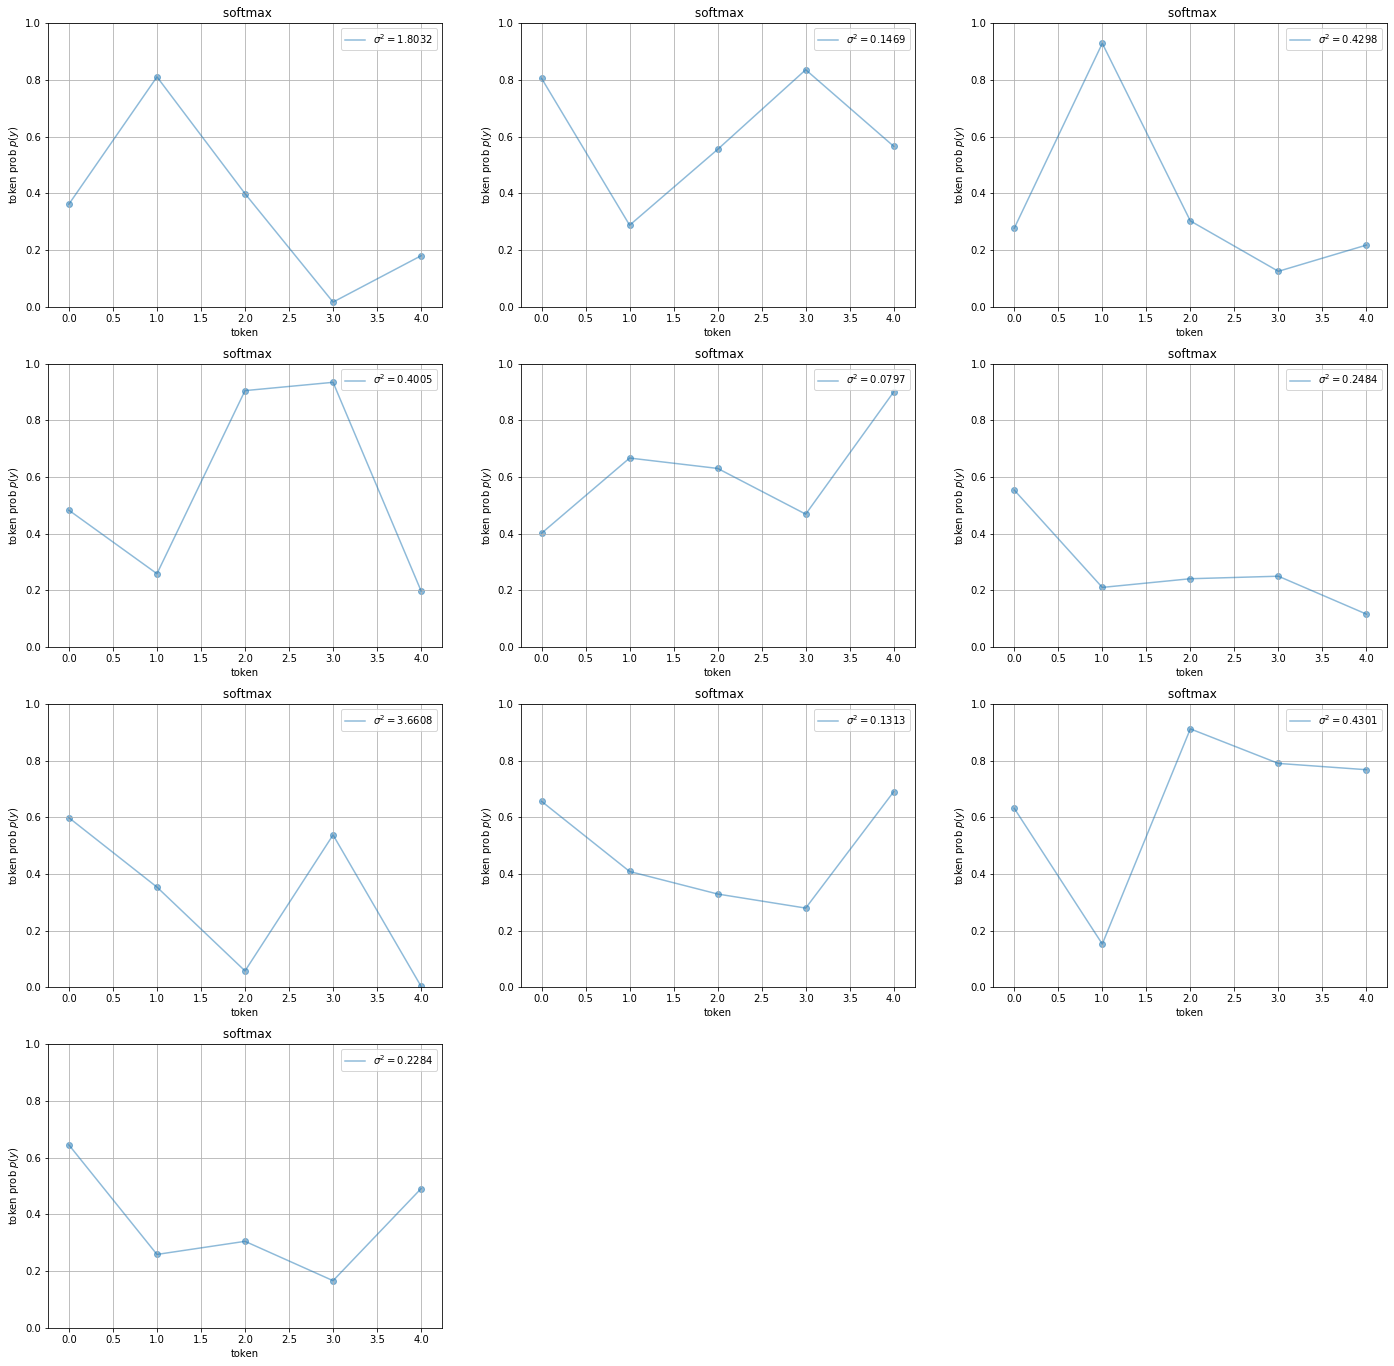

In [6]:
m = 3
n = len(probs_grid) // m + (1 if len(probs_grid) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, probs in enumerate(probs_grid):
    # assert np.sum(probs) == 1
    probs = np.array(probs)
    variance = np.var(np.log(probs + 1e-10))
    
    ax = plt.subplot(n, m, i + 1)
    plot_softmax(tokens, probs, '', r'$\sigma^2={:.4f}$'.format(variance), ax)

In [7]:
M = 15
N = len(tgt_dict.symbols)
tokens = np.arange(N)

probs_grid = []
for i in range(M):
    probs = []
    cumsum = 0
    for i in range(N):
        value = np.random.uniform(0, 1 - cumsum)
        cumsum += value
        probs.append(value)
        
    probs_grid.append(np.array(probs))

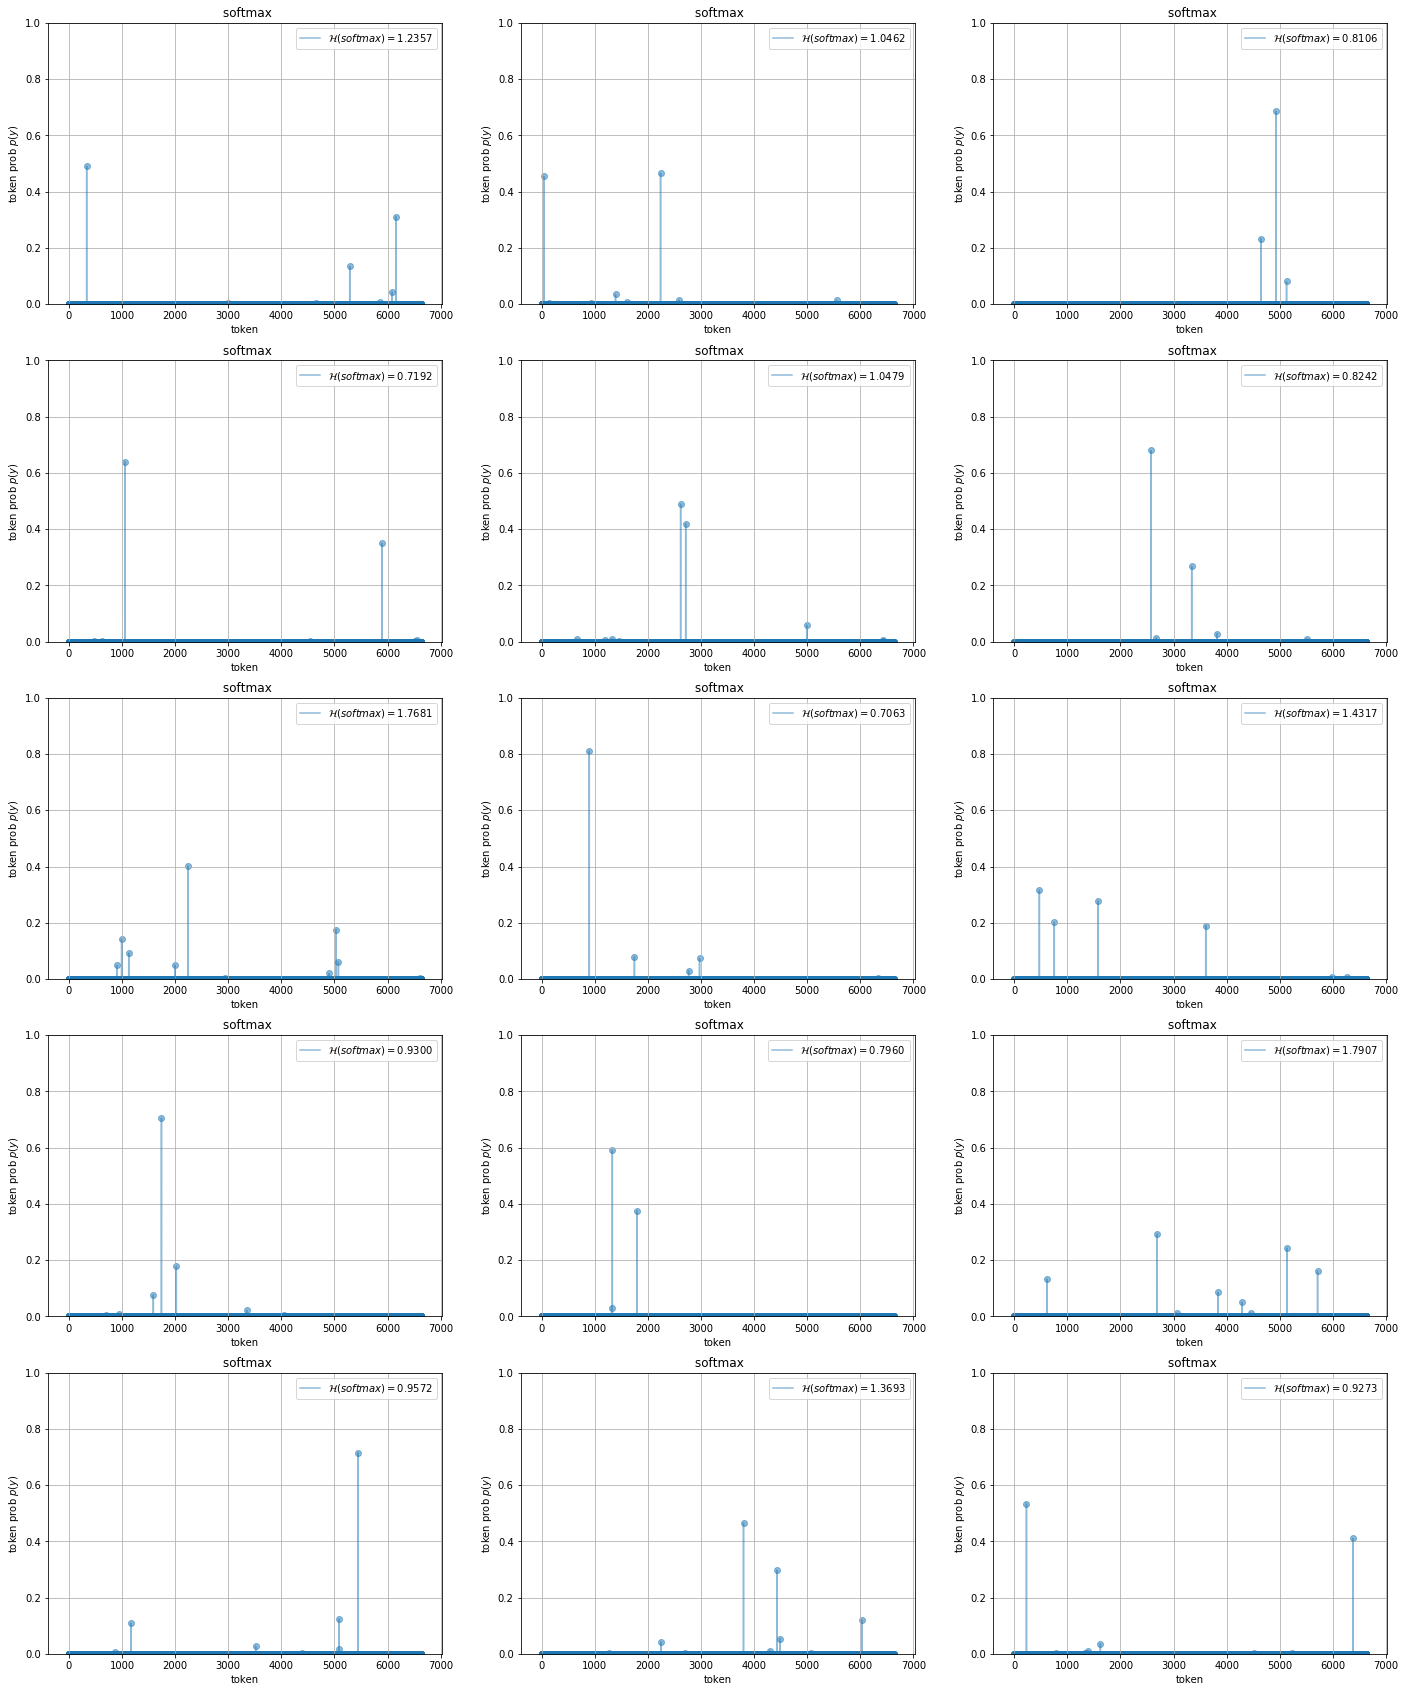

In [8]:
m = 3
n = len(probs_grid) // m + (1 if len(probs_grid) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, probs in enumerate(probs_grid):
    value = entropy(probs)
    
    ax = plt.subplot(n, m, i + 1)
    np.random.shuffle(probs)
    plot_softmax(tokens, probs, '', r'$\mathcal{{H}}(softmax)={:.4f}$'.format(value), ax)

In [9]:
M = 15
N = len(tgt_dict.symbols)
tokens = np.arange(N)

probs_grid = []
for i in range(M):
    variance = np.random.uniform(0, 10)
    probs = softmax(np.random.normal(0, variance, size=N))
    probs_grid.append(np.array(probs))

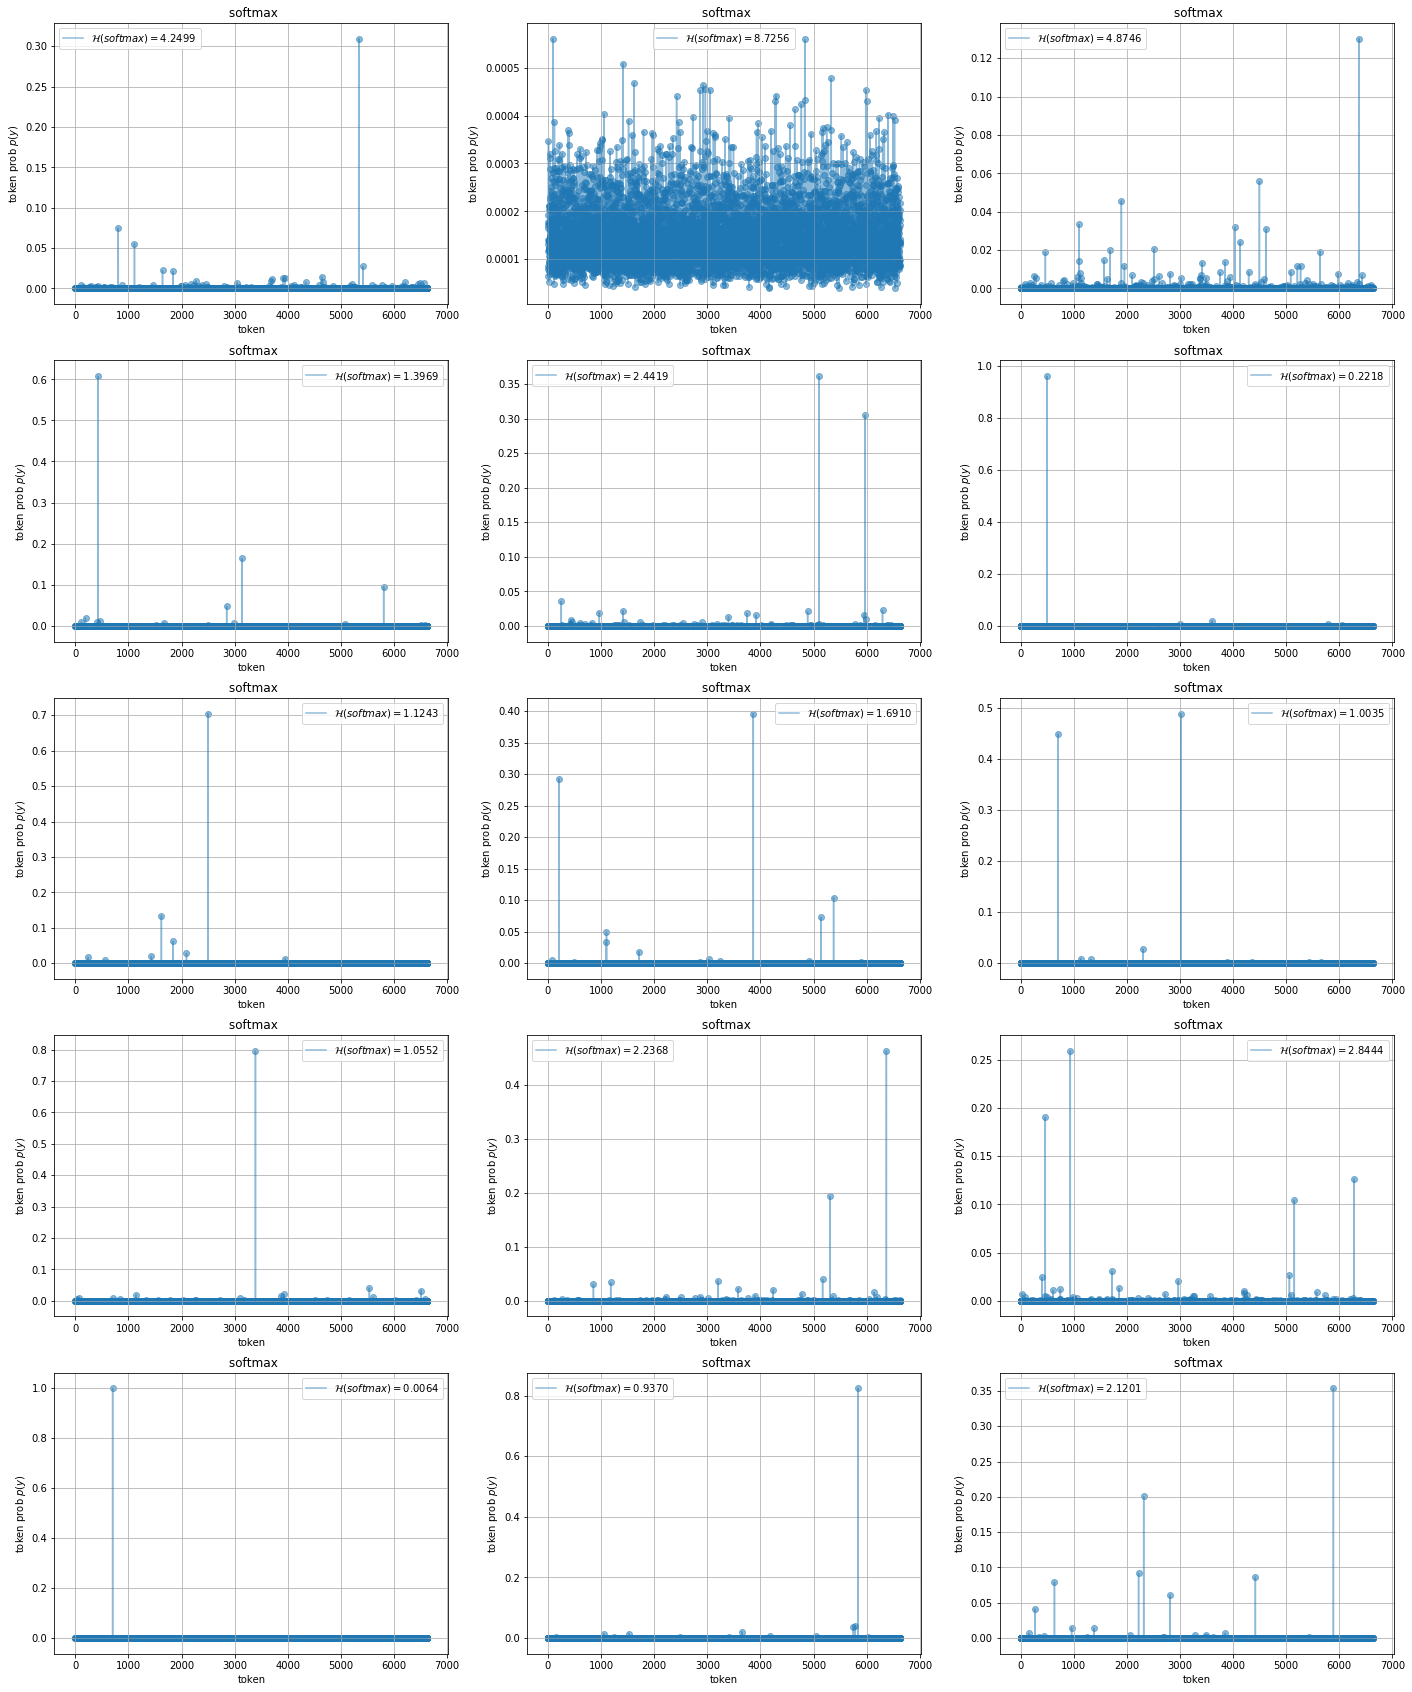

In [10]:
m = 3
n = len(probs_grid) // m + (1 if len(probs_grid) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, probs in enumerate(probs_grid):
    value = entropy(probs)
    
    ax = plt.subplot(n, m, i + 1)
    np.random.shuffle(probs)
    plot_softmax(tokens, probs, '', r'$\mathcal{{H}}(softmax)={:.4f}$'.format(value), ax, False)

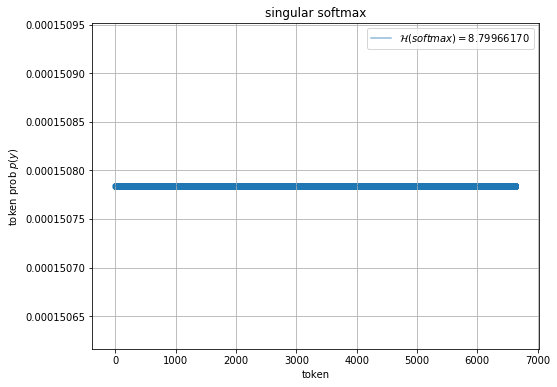

In [11]:
plt.figure(figsize=(8, 6))

N = len(tgt_dict.symbols)
tokens = np.arange(N)
probs = np.array([1 / N]* (N)) + 1e-10
value = entropy(probs)
    
ax = plt.subplot(1, 1, 1)
np.random.shuffle(probs)
plot_softmax(tokens, probs, 'singular', r'$\mathcal{{H}}(softmax)={:.8f}$'.format(value), ax, False)

---

In [12]:
def plot_single_stats(
    beams,
    beam2stats,
    stat,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    eos_token=None,
    map_func=lambda x: x
):
    density = stacked = normalized
        
    m = 3
    n = len(beams) // m  + (1 if len(beams) % m != 0 else 0)

    pos_name, beam2stats_pos = beam2stats
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, i + 1)
        ax.hist(
            map_func(beam2stats_pos[beam][stat]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='{} ({})'.format(pos_name, len(beam2stats_pos[beam][stat]))
        )
        if eos_token is not None:
            pos_stats = np.array(beam2stats_pos[beam][stat])
            mask = np.array(beam2stats_pos[beam]['tokens']) == eos_token
            ax.hist(
                map_func(pos_stats[mask]),
                density=density, stacked=stacked,
                color='gold', alpha=.4,
                bins=70,
                label='{}(eos) ({})'.format(pos_name, pos_stats[mask].shape[0])
            )
            
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

In [13]:
def plot_stats(
    beams,
    beam2stats_pos,
    beam2stats_neg,
    beam2stats_wrong,
    stat,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    eos_token=None,
    map_func=lambda x: x
):
    density = stacked = normalized
        
    m = 2
    n = len(beams)

    pos_name, beam2stats_pos = beam2stats_pos
    neg_name, beam2stats_neg = beam2stats_neg
    wrong_name, beam2stats_wrong = beam2stats_wrong
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, m * i + 1)
        ax.hist(
            map_func(beam2stats_pos[beam][stat]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='{} ({})'.format(pos_name, len(beam2stats_pos[beam][stat]))
        )
        if eos_token is not None:
            pos_stats = np.array(beam2stats_pos[beam][stat])
            mask = np.array(beam2stats_pos[beam]['tokens']) == eos_token
            ax.hist(
                map_func(pos_stats[mask]),
                density=density, stacked=stacked,
                color='gold', alpha=.4,
                bins=70,
                label='{}(eos) ({})'.format(pos_name, pos_stats[mask].shape[0])
            )
            
        ax.hist(
            map_func(beam2stats_neg[beam][stat]),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='{} ({})'.format(neg_name, len(beam2stats_neg[beam][stat]))
        )
        if eos_token is not None:
            neg_stats = np.array(beam2stats_neg[beam][stat])
            mask = np.array(beam2stats_neg[beam]['tokens']) == eos_token
            ax.hist(
                map_func(neg_stats[mask]),
                density=density, stacked=stacked,
                color='green', alpha=.4,
                bins=70,
                label='{} (eos) ({})'.format(neg_name, neg_stats[mask].shape[0])
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

        ax = plt.subplot(n, m, m * i + 2)
        wrong_stat = np.array(beam2stats_wrong[beam][stat])
        pos_mask = np.array(beam2stats_wrong[beam]['is_true'])
        if eos_token is not None:
            eos_mask = np.array(beam2stats_wrong[beam]['tokens']) == eos_token
        ax.hist(
            map_func(wrong_stat[pos_mask]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='{} positive ({})'.format(wrong_name, wrong_stat[pos_mask].shape[0])
        )
        if eos_token is not None:
            ax.hist(
                map_func(wrong_stat[pos_mask & eos_mask]),
                density=density, stacked=stacked,
                color='gold', alpha=.4,
                bins=70,
                label='{} positive(eos) ({})'.format(wrong_name, wrong_stat[pos_mask & eos_mask].shape[0])
            )
        ax.hist(
            map_func(wrong_stat[~pos_mask]),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='{} negative ({})'.format(wrong_name, wrong_stat[~pos_mask].shape[0])
        )
        if eos_token is not None:
            ax.hist(
                map_func(wrong_stat[(~pos_mask) & eos_mask]),
                density=density, stacked=stacked,
                color='green', alpha=.4,
                bins=70,
                label='{} negative(eos) ({})'.format(wrong_name, wrong_stat[(~pos_mask) & eos_mask].shape[0])
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

In [14]:
def plot_stats_scatters(
    beams,
    beam2stats_first,
    beam2stats_second,
    stat_x,
    stat_y,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    eos_token=None,
    map_func_x=lambda x: x,
    map_func_y=lambda x: x
):
    density = stacked = normalized
        
    m = 2
    n = len(beams)

    first_name, beam2stats_first = beam2stats_first
    second_name, beam2stats_second = beam2stats_second
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, m * i + 1)
        ax.scatter(
            map_func_x(beam2stats_first[beam][stat_x]),
            map_func_y(beam2stats_first[beam][stat_y]),
            color='red', alpha=.4,
            label='{}'.format(first_name)
        )
        if eos_token is not None:
            stats_x = np.array(beam2stats_first[beam][stat_x])
            stats_y = np.array(beam2stats_first[beam][stat_y])
            mask = np.array(beam2stats_first[beam]['tokens']) == eos_token
            ax.scatter(
                map_func_x(stats_x[mask]),
                map_func_y(stats_y[mask]),
                color='gold', alpha=.4,
                label='{}(eos)'.format(first_name)
            )
            
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

        ax = plt.subplot(n, m, m * i + 2)
        ax.scatter(
            map_func_x(beam2stats_second[beam][stat_x]),
            map_func_y(beam2stats_second[beam][stat_y]),
            color='blue', alpha=.4,
            label='{}'.format(second_name)
        )
        if eos_token is not None:
            stats_x = np.array(beam2stats_second[beam][stat_x])
            stats_y = np.array(beam2stats_second[beam][stat_y])
            mask = np.array(beam2stats_second[beam]['tokens']) == eos_token
            ax.scatter(
                map_func_x(stats_x[mask]),
                map_func_y(stats_y[mask]),
                color='green', alpha=.4,
                label='{}(eos)'.format(second_name)
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

In [16]:
stats_dir = 'mtransformer/de-en/correct_stats_with_random/'

positive_filename = 'positive_stats.json'
negative_filename = 'negative_stats.json'
negative_true_filename = 'negative_true_stats.json'
wrong_filename = 'wrong_suff_stats.json'
random_filename = 'random_stats.json'

In [17]:
beam2stats_pos = defaultdict(list)
beam2stats_neg = defaultdict(list)
beam2stats_neg_true = defaultdict(list)
beam2stats_wrong = defaultdict(list)
beam2stats_random = defaultdict(list)

In [18]:
for beam_dir in os.listdir(stats_dir):
    beam = int(beam_dir.split('_')[-1])
    
    path = os.path.join(stats_dir, beam_dir)
    with open(os.path.join(path, positive_filename)) as input_stream:
        beam2stats_pos[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_filename)) as input_stream:
        beam2stats_neg[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_true_filename)) as input_stream:
        beam2stats_neg_true[beam] = json.load(input_stream)
        
    with open(os.path.join(path, wrong_filename)) as input_stream:
        beam2stats_wrong[beam] = json.load(input_stream)
        
    with open(os.path.join(path, random_filename)) as input_stream:
        beam2stats_random[beam] = json.load(input_stream)

#### Log probs

In [19]:
beams = list(beam2stats_pos.keys())

---

#### Token-level variance

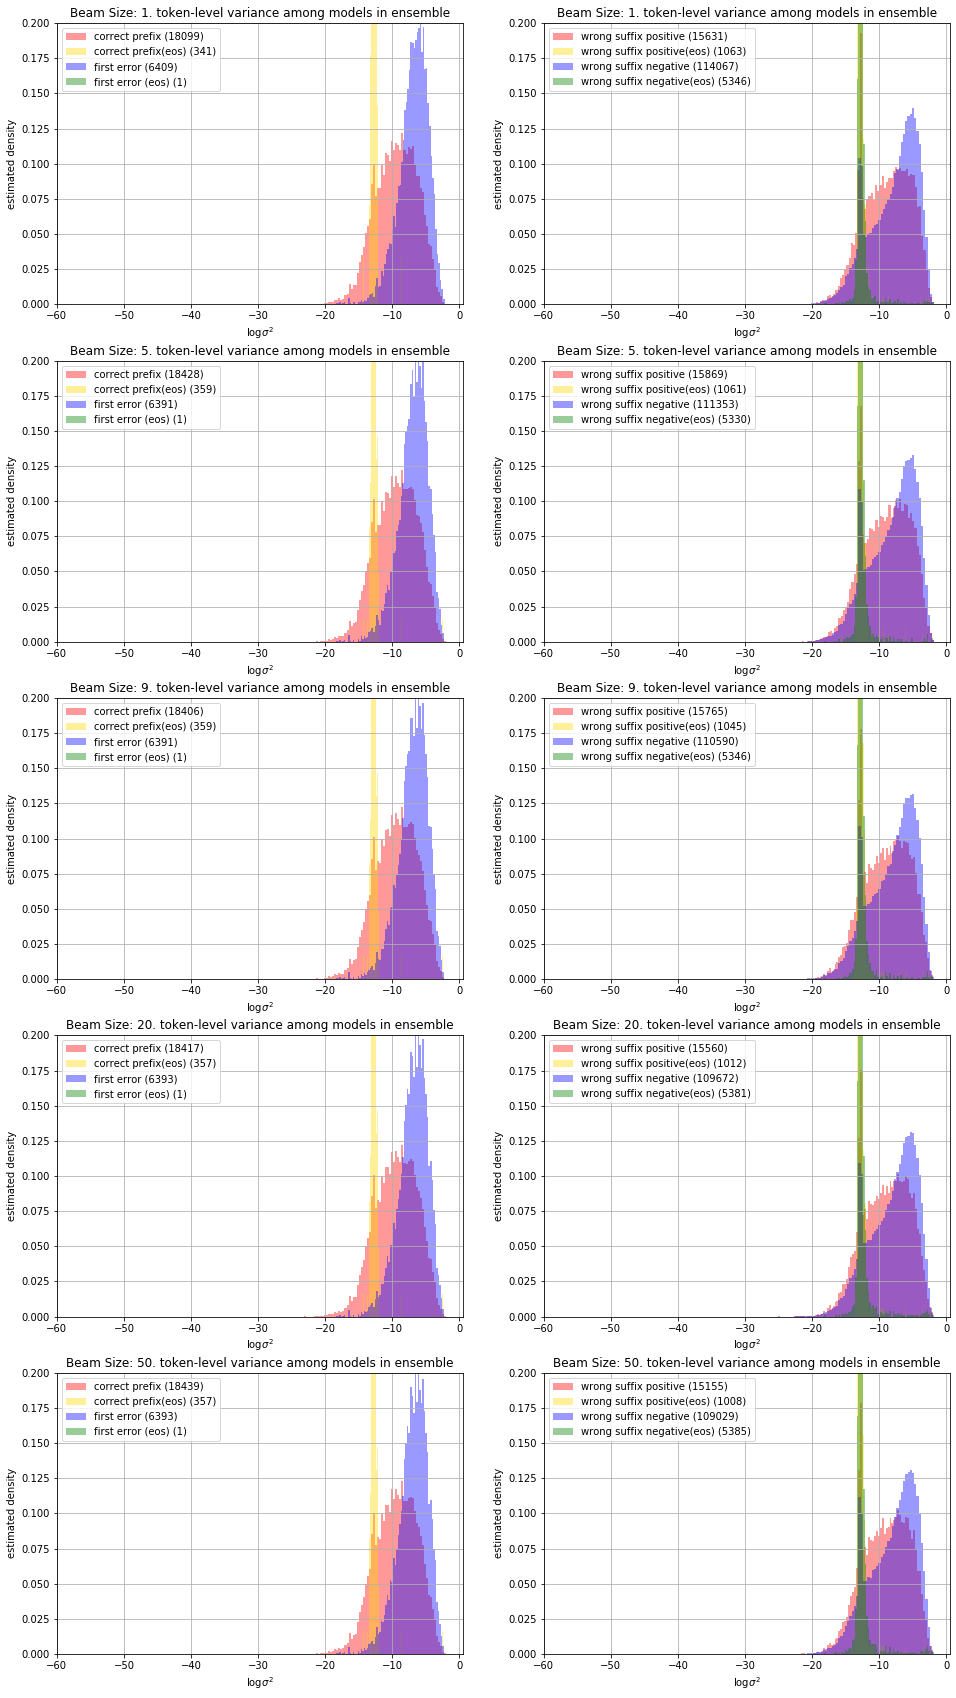

In [20]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models in ensemble'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT = 'inens_probs_var'
EOS_TOKEN = tgt_dict.eos()
# EOS_TOKEN = None

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.log2
)

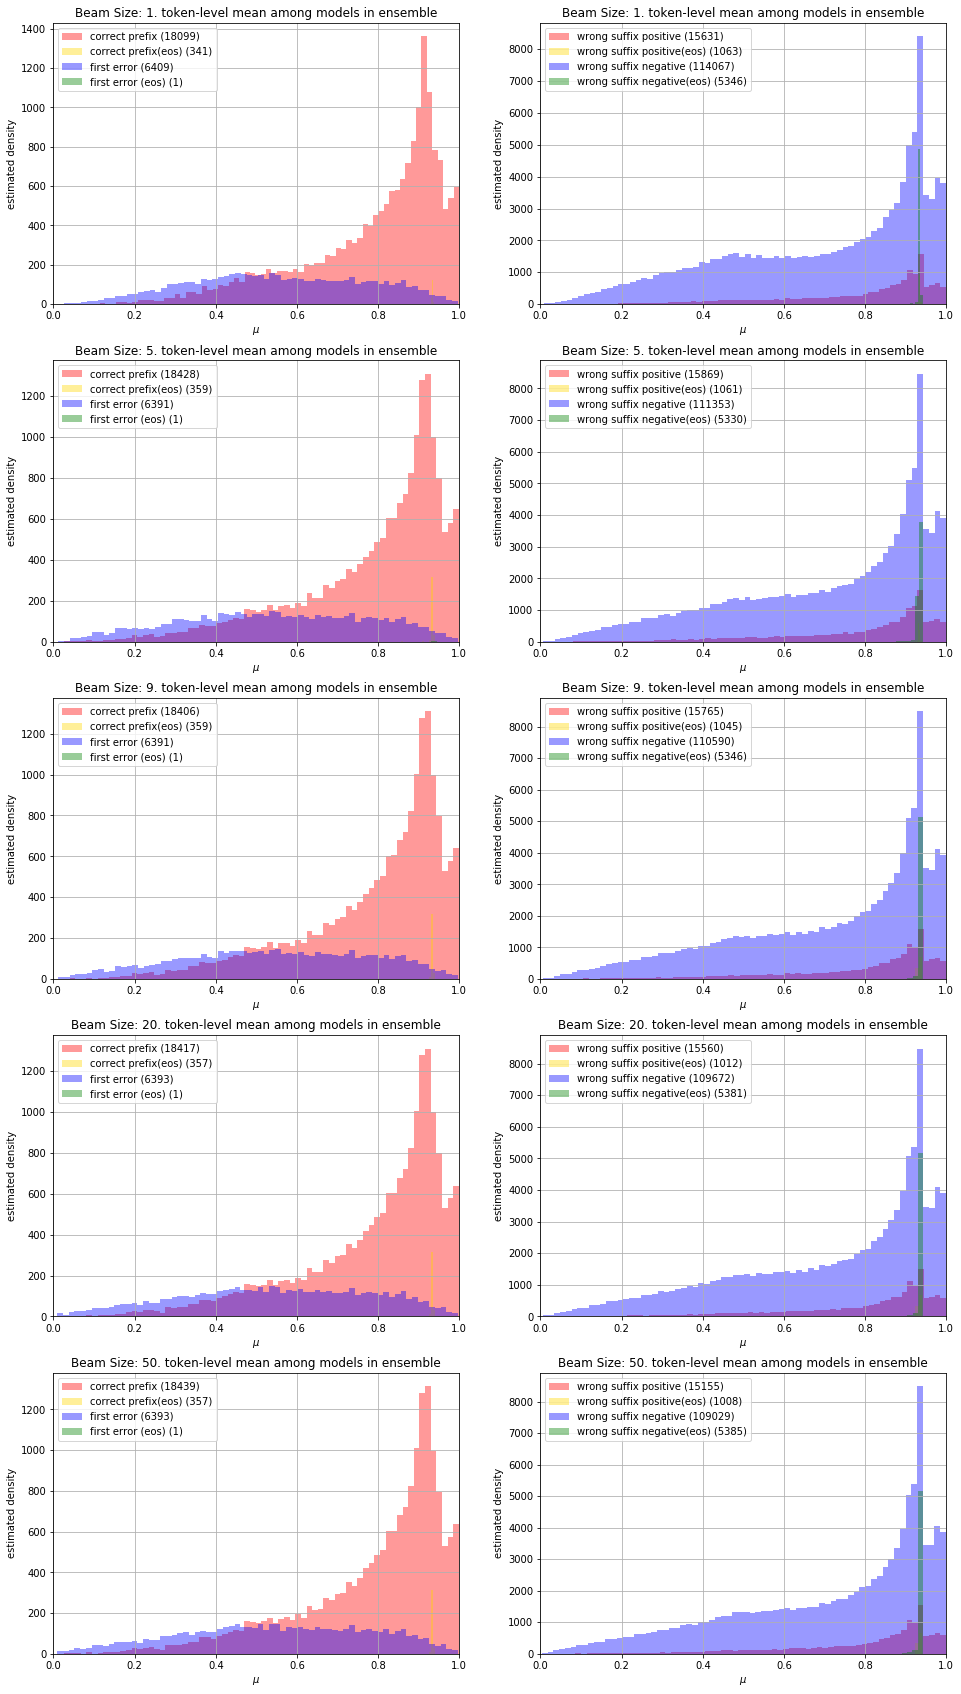

In [21]:
YLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None


XLIM, YLIM = None, None
XLIM = (0, 1)

TITLE = 'token-level mean among models in ensemble'
XLABEL = r'$\mu$'
YLABEL = 'estimated density'

STAT = 'inens_probs_mean'
EOS_TOKEN = tgt_dict.eos()

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.exp
)

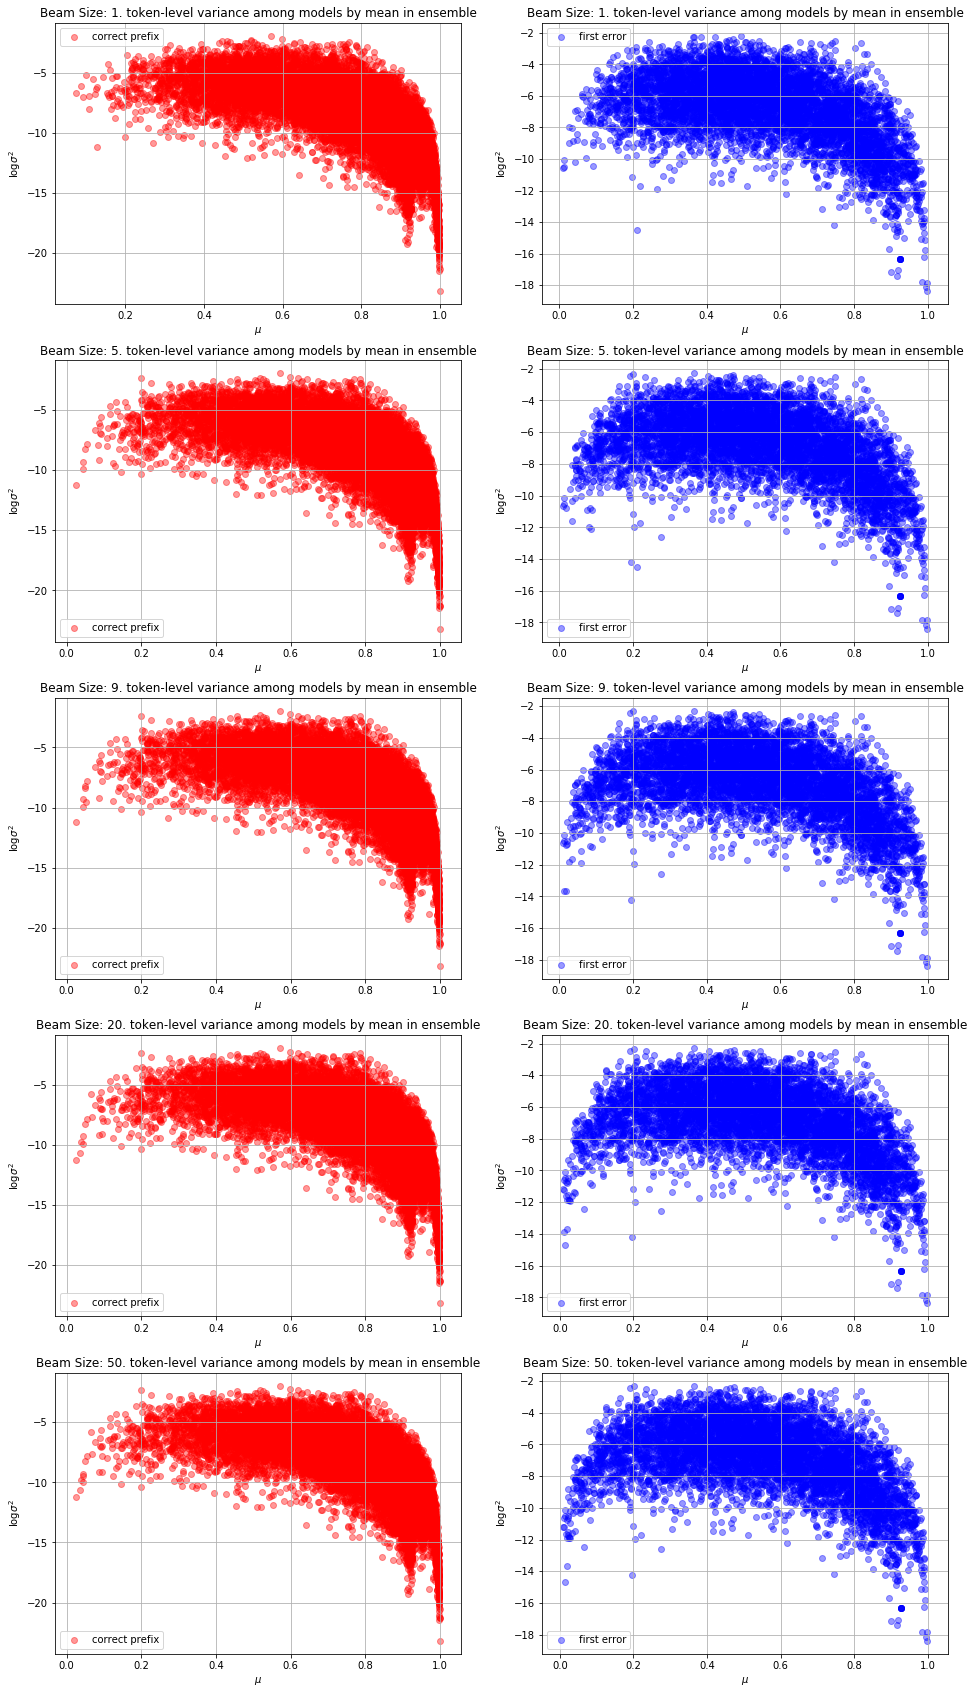

In [22]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models by mean in ensemble'
YLABEL = r'$\log \sigma^2$'
XLABEL = r'$\mu$'

STATX = 'inens_probs_mean'
STATY = 'inens_probs_var'
EOS_TOKEN = None

plot_stats_scatters(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    STATX,
    STATY,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    map_func_x=np.exp,
    map_func_y=np.log2
)

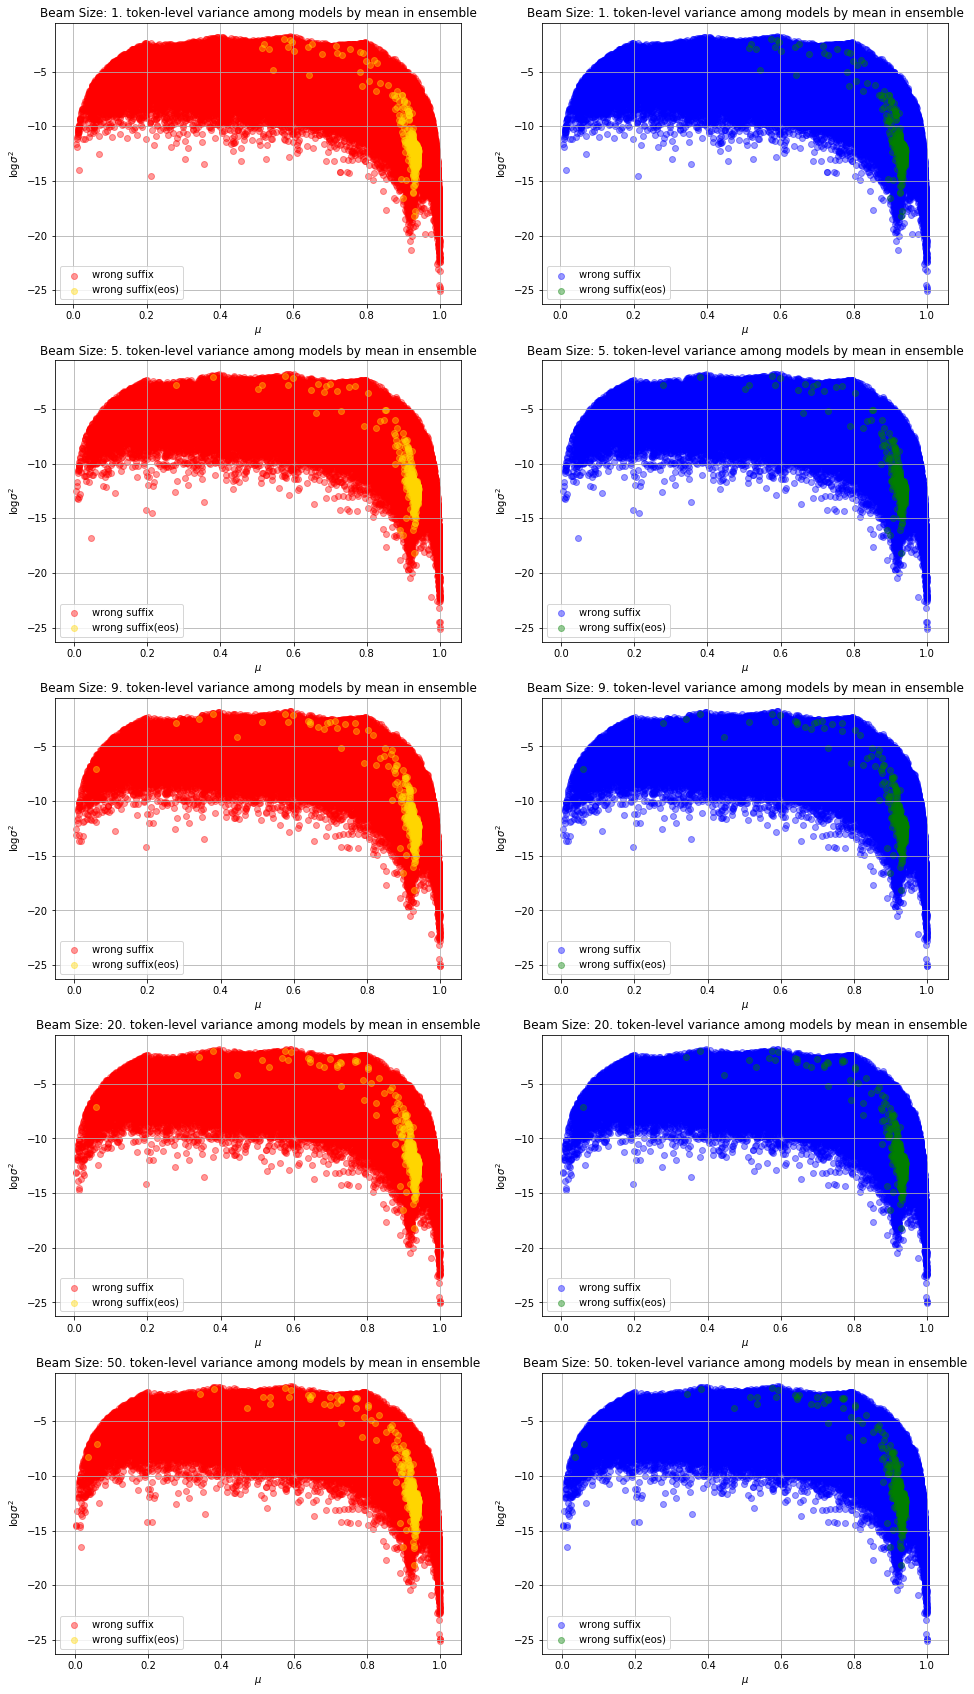

In [23]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models by mean in ensemble'
YLABEL = r'$\log \sigma^2$'
XLABEL = r'$\mu$'

STATX = 'inens_probs_mean'
STATY = 'inens_probs_var'
EOS_TOKEN = tgt_dict.eos()

plot_stats_scatters(
    beams,
    ('wrong suffix', beam2stats_wrong),
    ('wrong suffix', beam2stats_wrong),
    STATX,
    STATY,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    map_func_x=np.exp,
    map_func_y=np.log2
)

/home/dkuznetsov/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6781: RuntimeWarning: invalid value encountered in true_divide
  m[:] = (m / db) / tops[-1].sum()


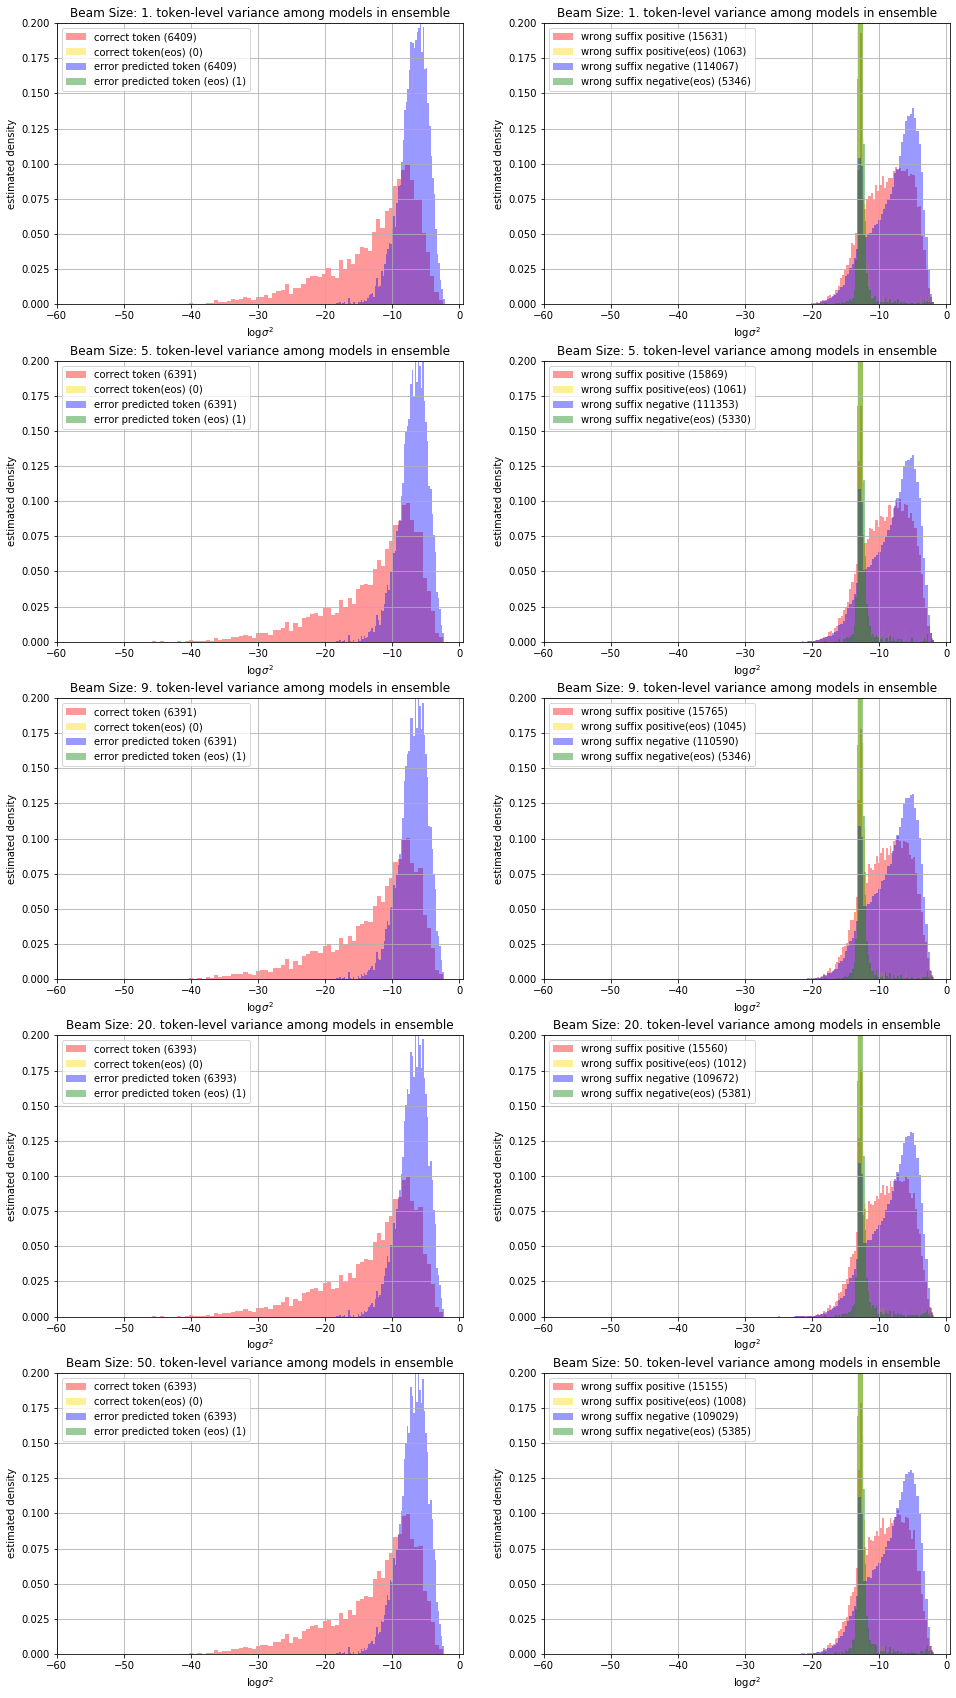

In [24]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models in ensemble'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT = 'inens_probs_var'
EOS_TOKEN = tgt_dict.eos()

plot_stats(
    beams,
    ('correct token', beam2stats_neg_true),
    ('error predicted token', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.log2
)

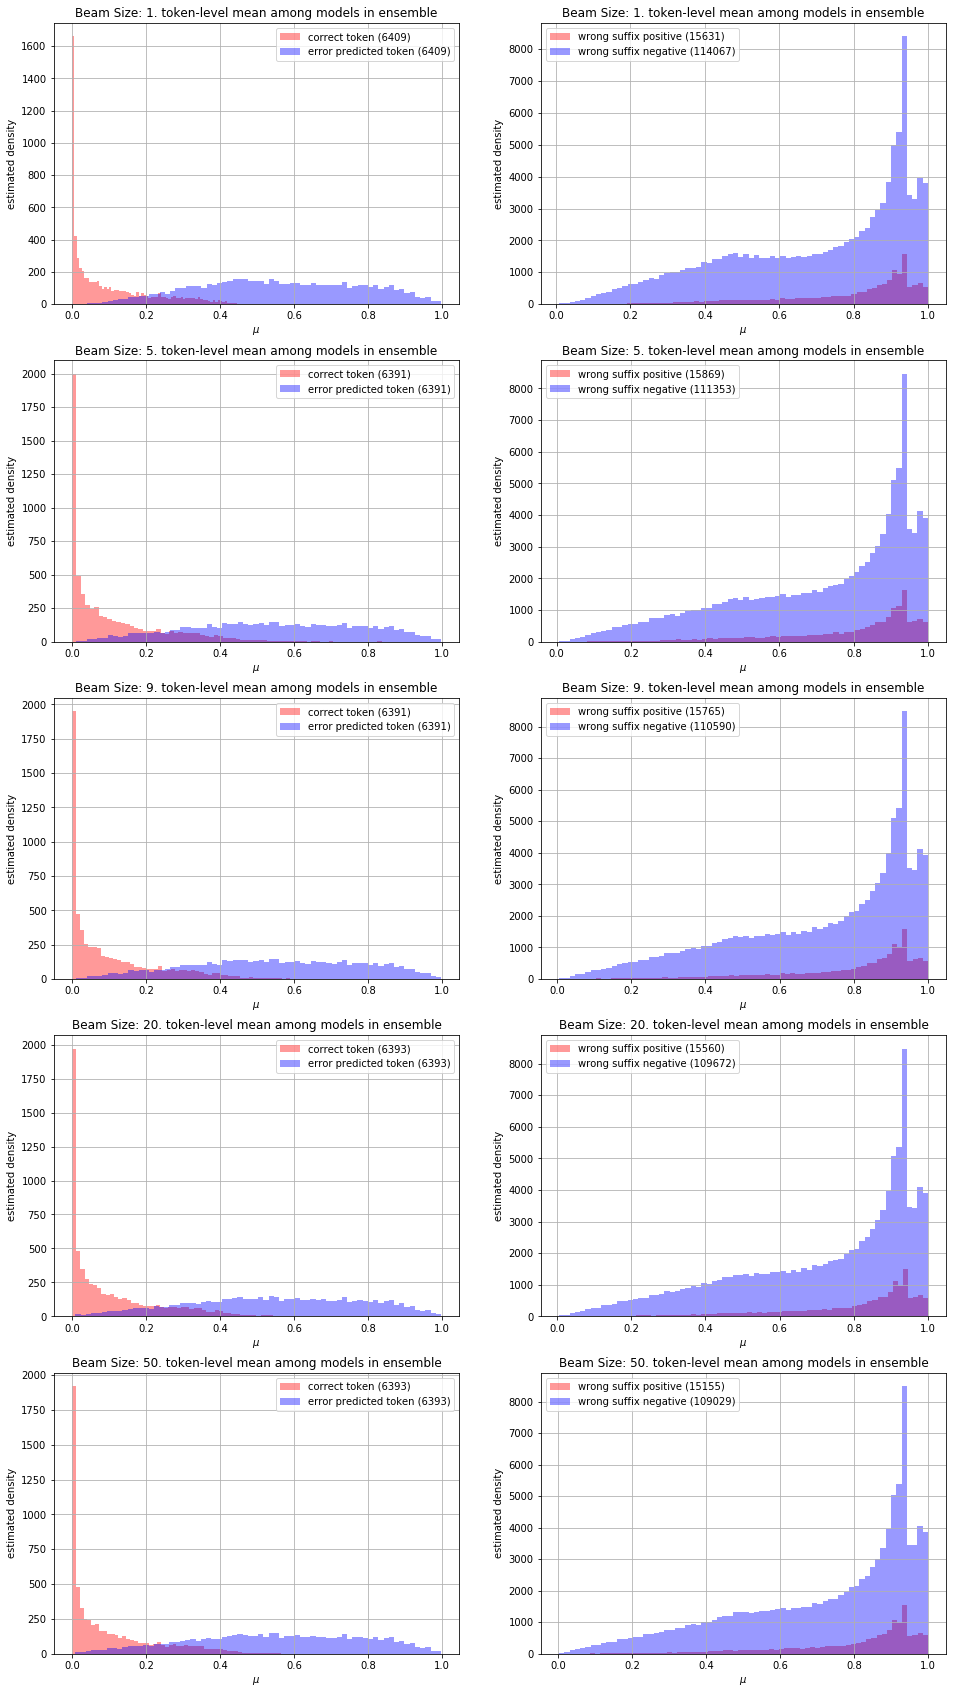

In [25]:
YLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLIM, YLIM = None, None

TITLE = 'token-level mean among models in ensemble'
XLABEL = r'$\mu$'
YLABEL = 'estimated density'

STAT = 'inens_probs_mean'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct token', beam2stats_neg_true),
    ('error predicted token', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.exp
)

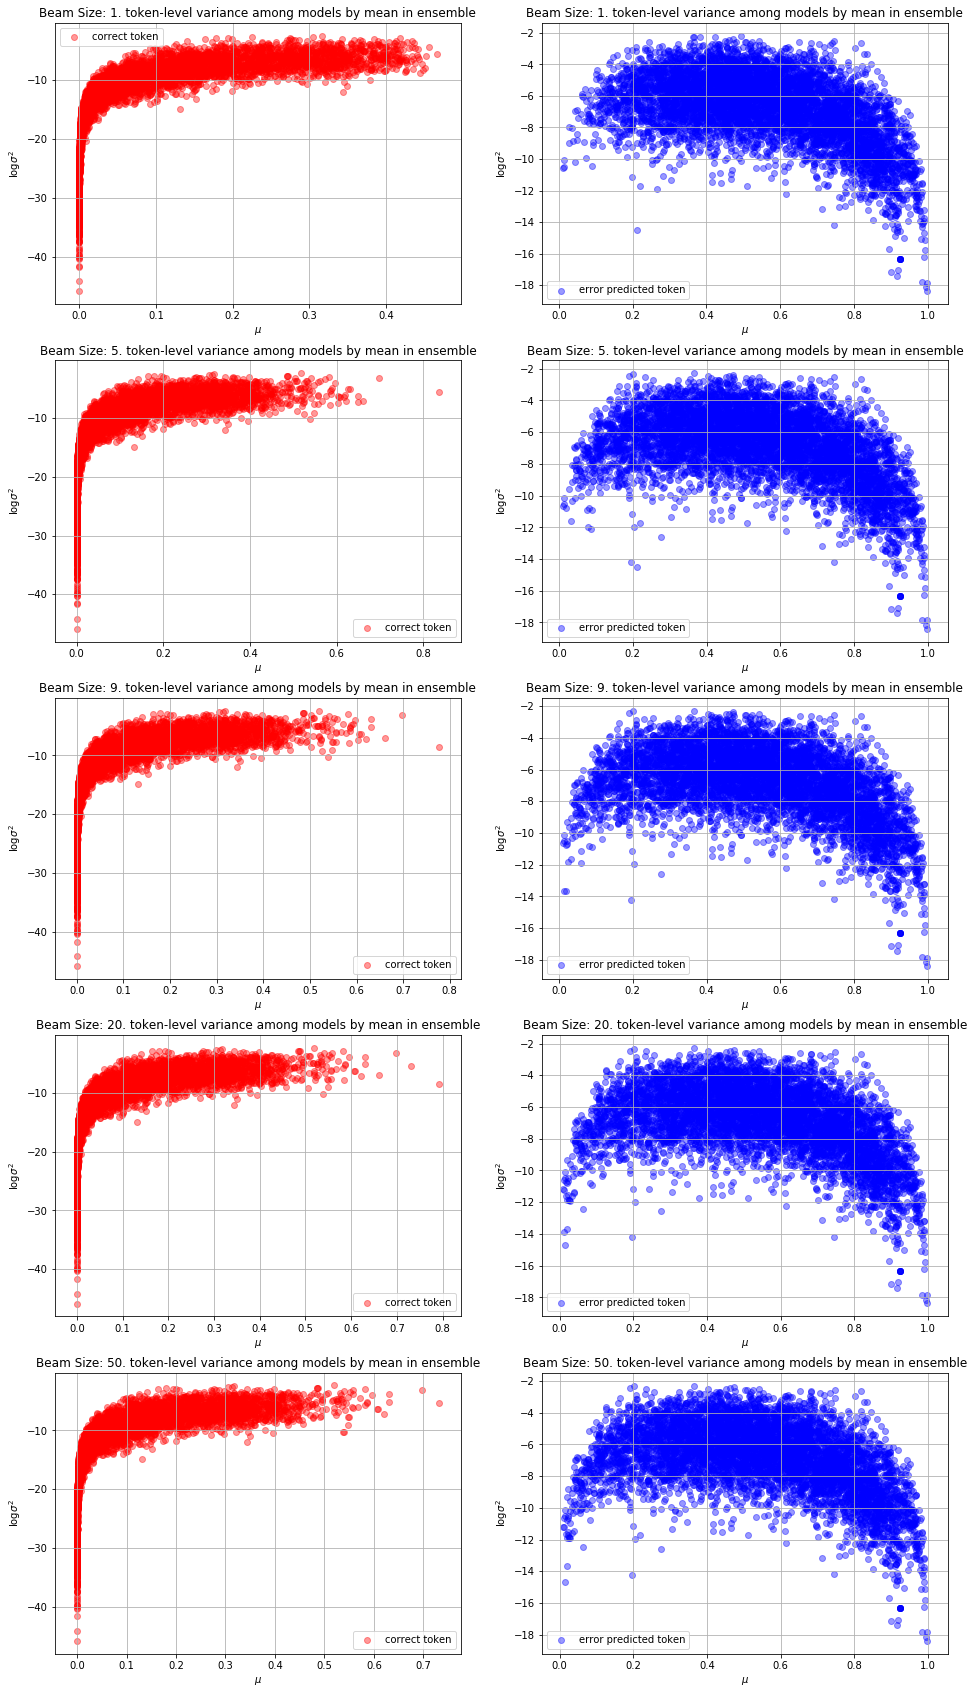

In [26]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models by mean in ensemble'
YLABEL = r'$\log \sigma^2$'
XLABEL = r'$\mu$'

STATX = 'inens_probs_mean'
STATY = 'inens_probs_var'
EOS_TOKEN = None

plot_stats_scatters(
    beams,
    ('correct token', beam2stats_neg_true),
    ('error predicted token', beam2stats_neg),
    STATX,
    STATY,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    map_func_x=np.exp,
    map_func_y=np.log2
)

In [27]:
pos_neg_diff_stats = defaultdict(dict)
for score, func in zip(['inens_probs_var', 'inens_probs_mean'], [lambda x: x, lambda x: np.exp(x)]):
    for beam in beams:
        pos = np.array(func(beam2stats_neg_true[beam][score]))
        neg = np.array(func(beam2stats_neg[beam][score]))
        
        pos_neg_diff_stats[beam][score] = (neg - pos).tolist()

/home/dkuznetsov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log2
/home/dkuznetsov/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dkuznetsov/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


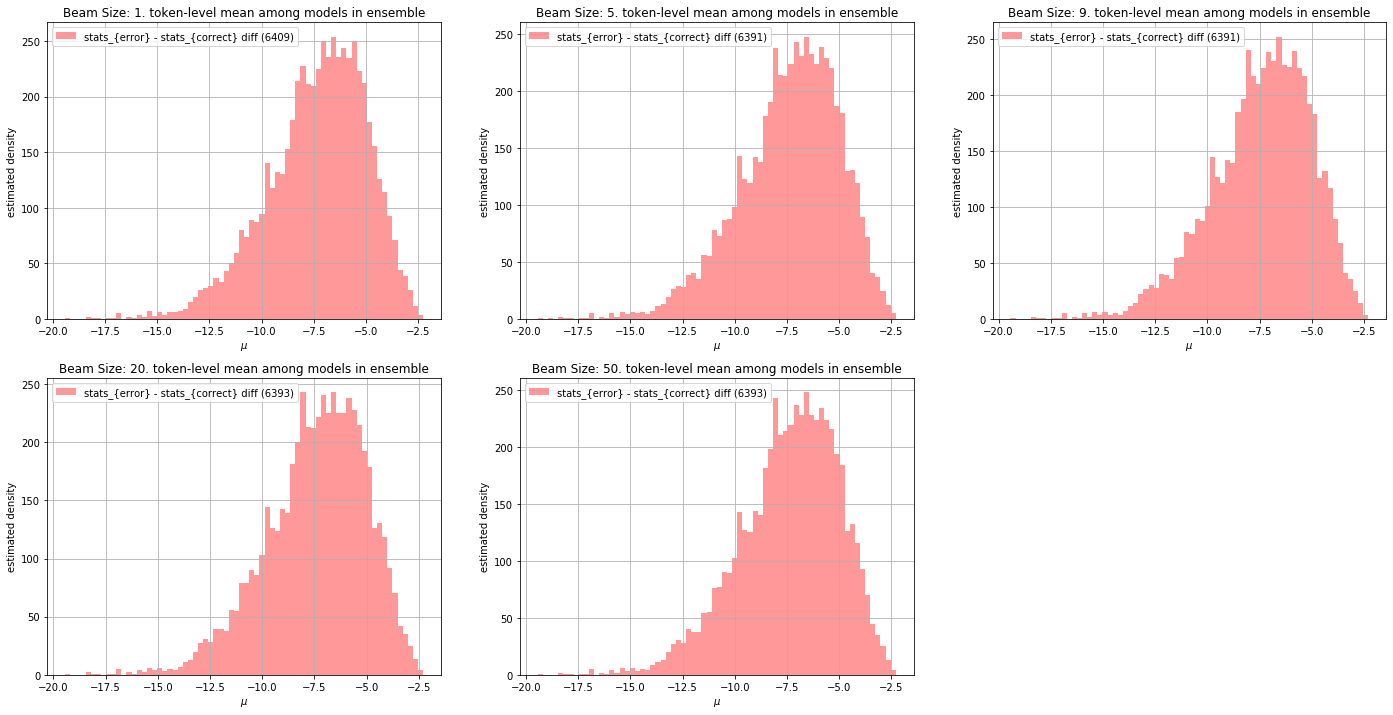

In [28]:
YLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLIM, YLIM = None, None

TITLE = 'token-level mean among models in ensemble'
XLABEL = r'$\mu$'
YLABEL = 'estimated density'

STAT = 'inens_probs_var'
EOS_TOKEN = None

plot_single_stats(
    beams,
    (r'stats_{error} - stats_{correct} diff', pos_neg_diff_stats),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.log2
)

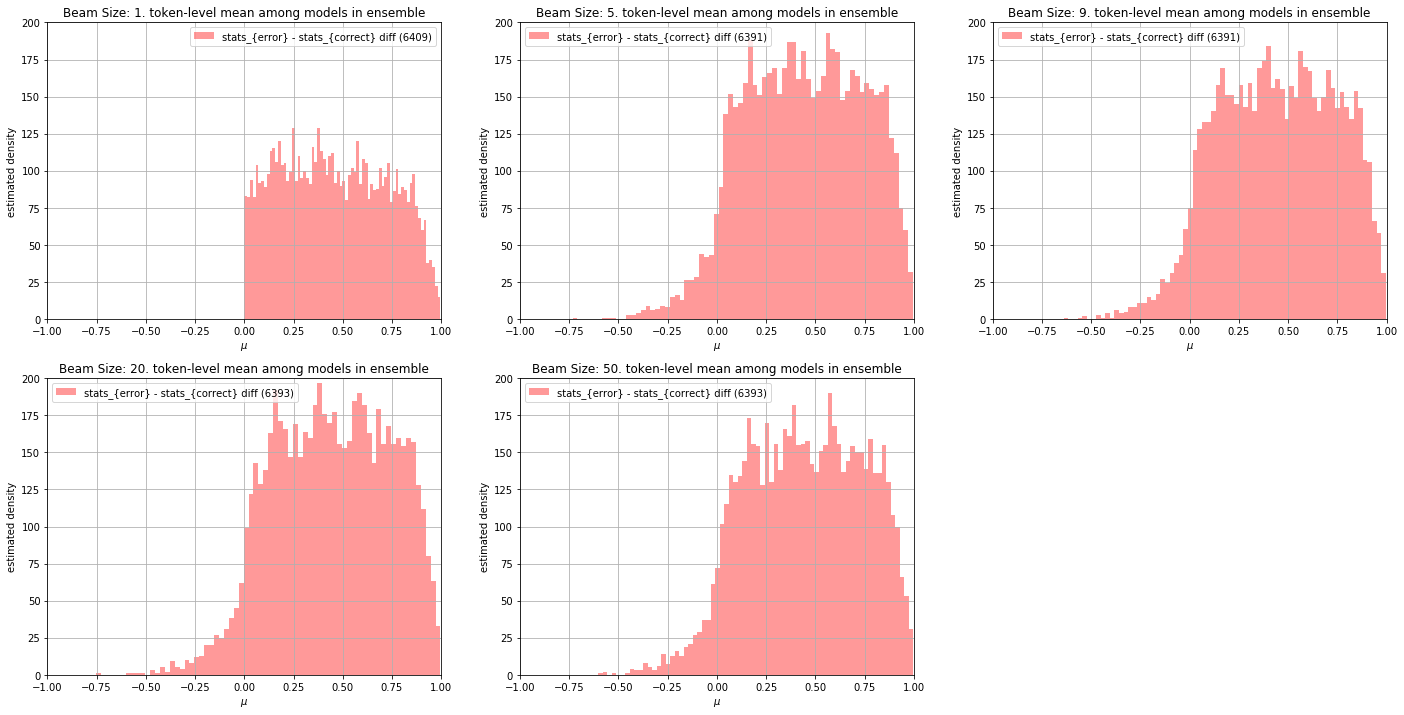

In [29]:
YLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLIM, YLIM = None, None
YLIM = (0, 200)
XLIM = (-1, 1)

TITLE = 'token-level mean among models in ensemble'
XLABEL = r'$\mu$'
YLABEL = 'estimated density'

STAT = 'inens_probs_mean'
EOS_TOKEN = None

plot_single_stats(
    beams,
    (r'stats_{error} - stats_{correct} diff', pos_neg_diff_stats),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN
)

/home/dkuznetsov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log2
/home/dkuznetsov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in log2


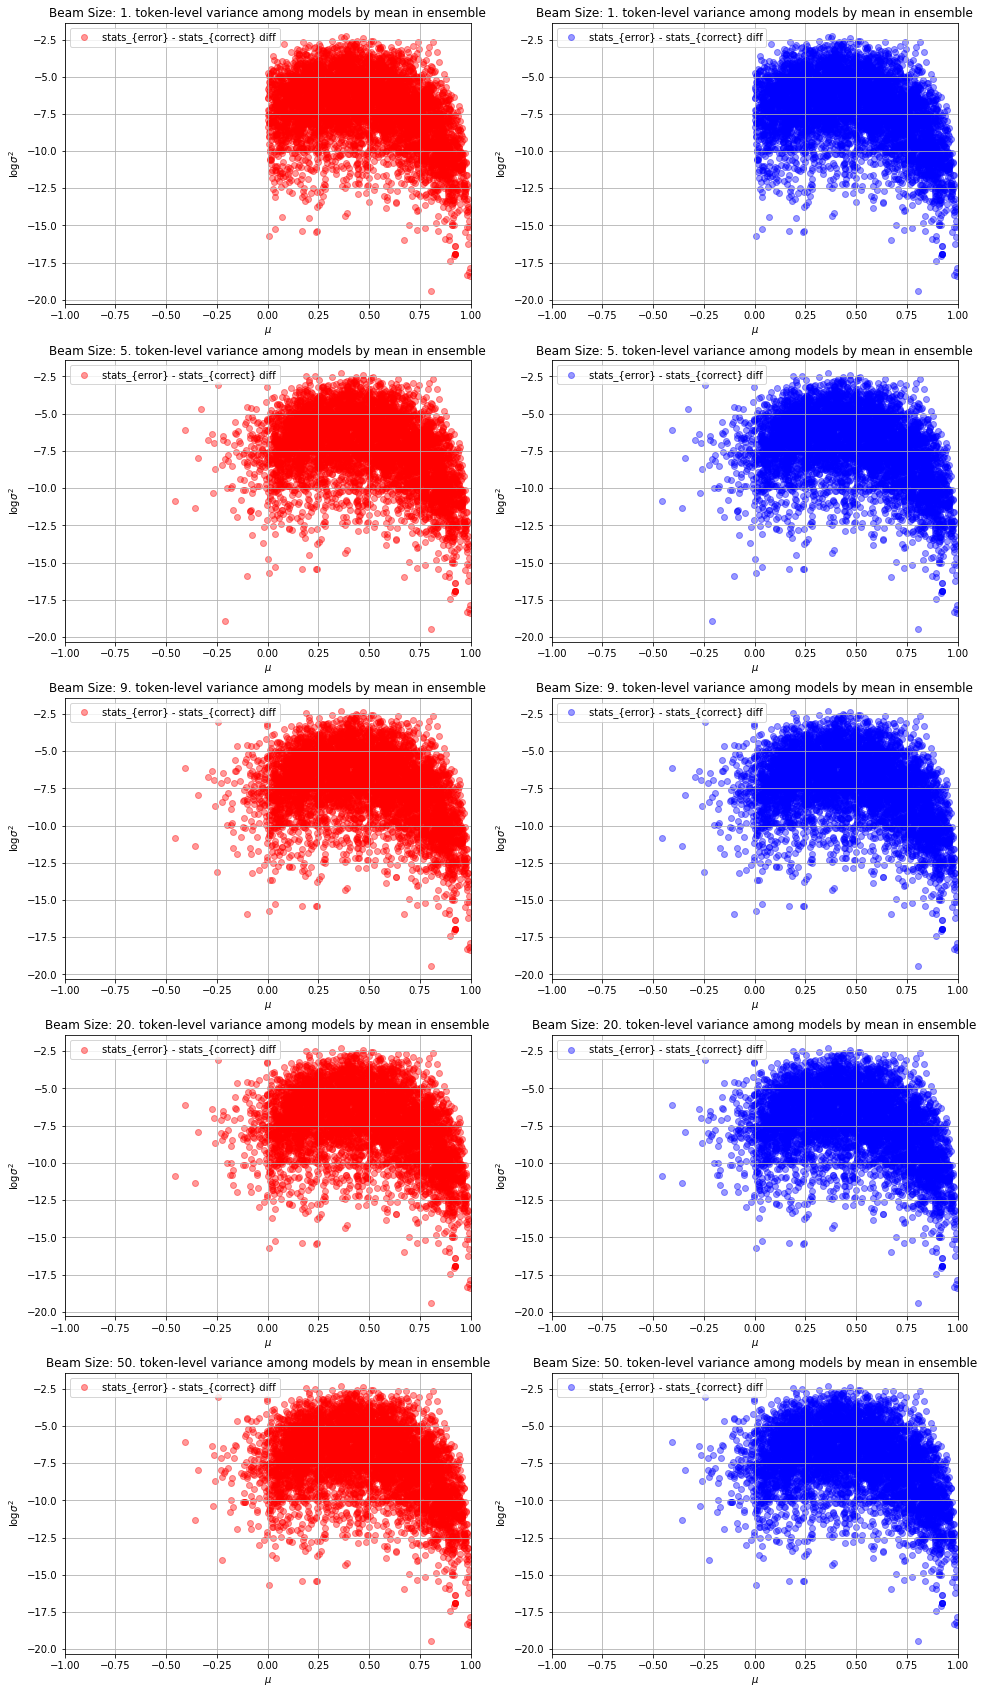

In [30]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None
XLIM = (-1, 1)

TITLE = 'token-level variance among models by mean in ensemble'
YLABEL = r'$\log \sigma^2$'
XLABEL = r'$\mu$'

STATX = 'inens_probs_mean'
STATY = 'inens_probs_var'
EOS_TOKEN = None

plot_stats_scatters(
    beams,
    (r'stats_{error} - stats_{correct} diff', pos_neg_diff_stats),
    (r'stats_{error} - stats_{correct} diff', pos_neg_diff_stats),
    STATX,
    STATY,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    map_func_y=np.log2
)

#### Ensemble softmax variance

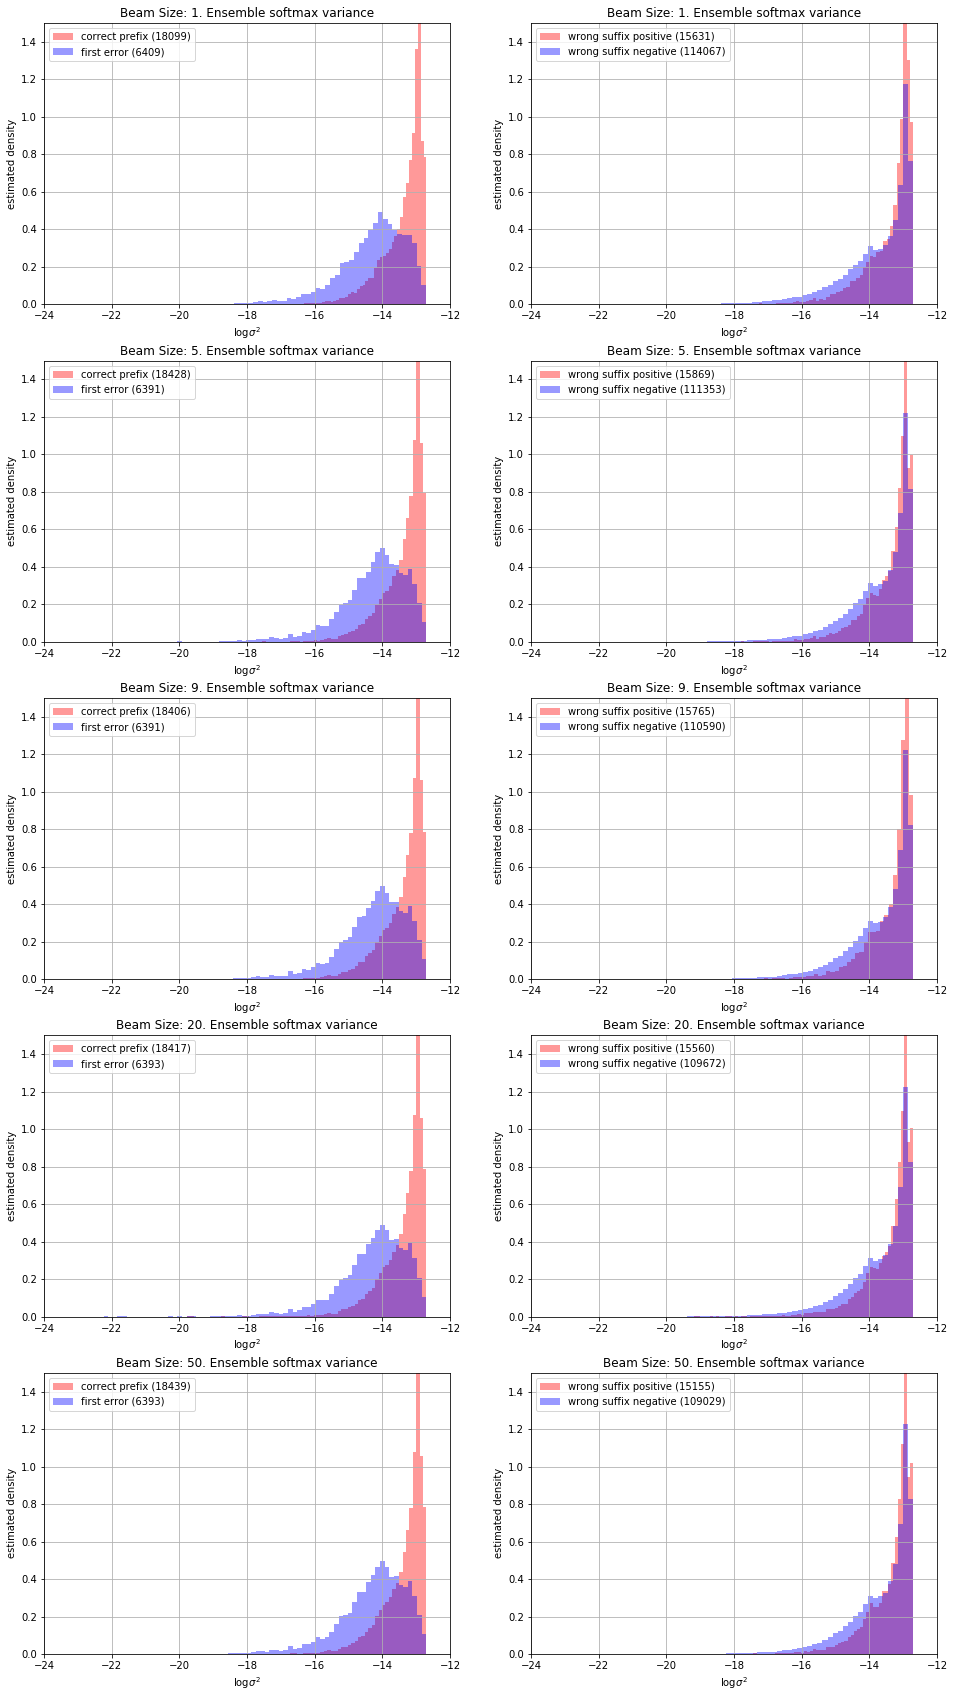

In [31]:
YLIM = (0, 1.5)
XLIM = (-24, -12)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble softmax variance'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT = 'softmax_probs_var_ens'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.log2
)

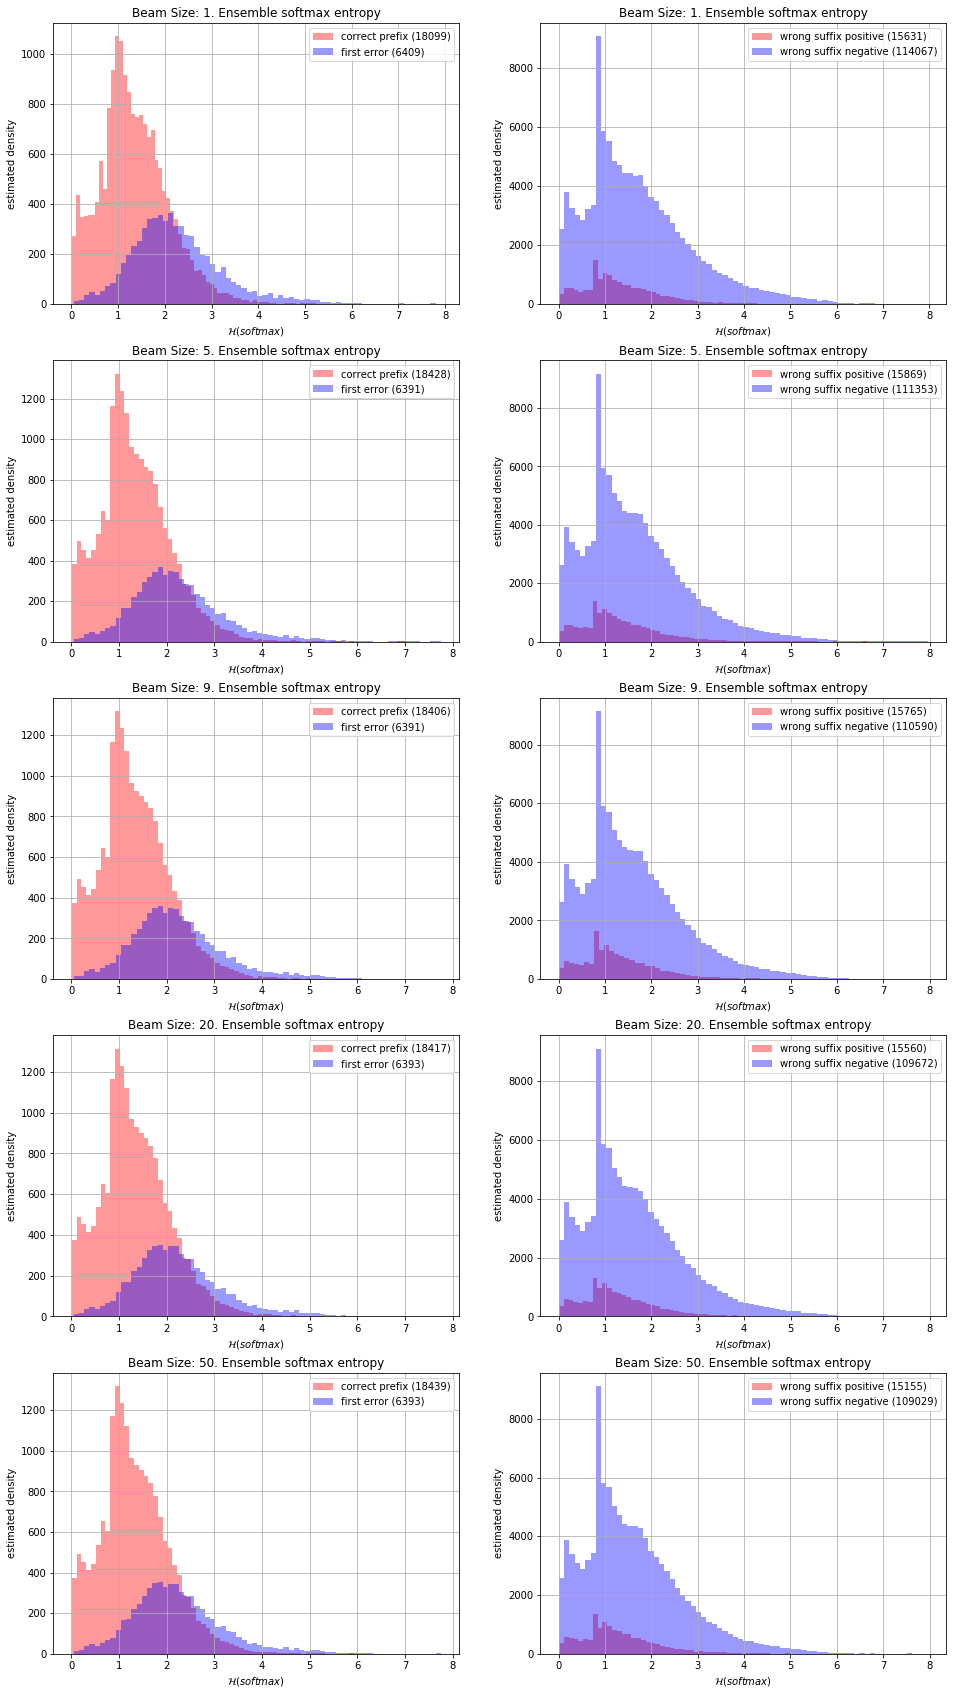

In [32]:
YLIM = (0, 1)
XLIM = None

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble softmax entropy'
XLABEL = r'$\mathcal{H}(softmax)$'
YLABEL = 'estimated density'

STAT = 'softmax_probs_entropy_ens'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN
)

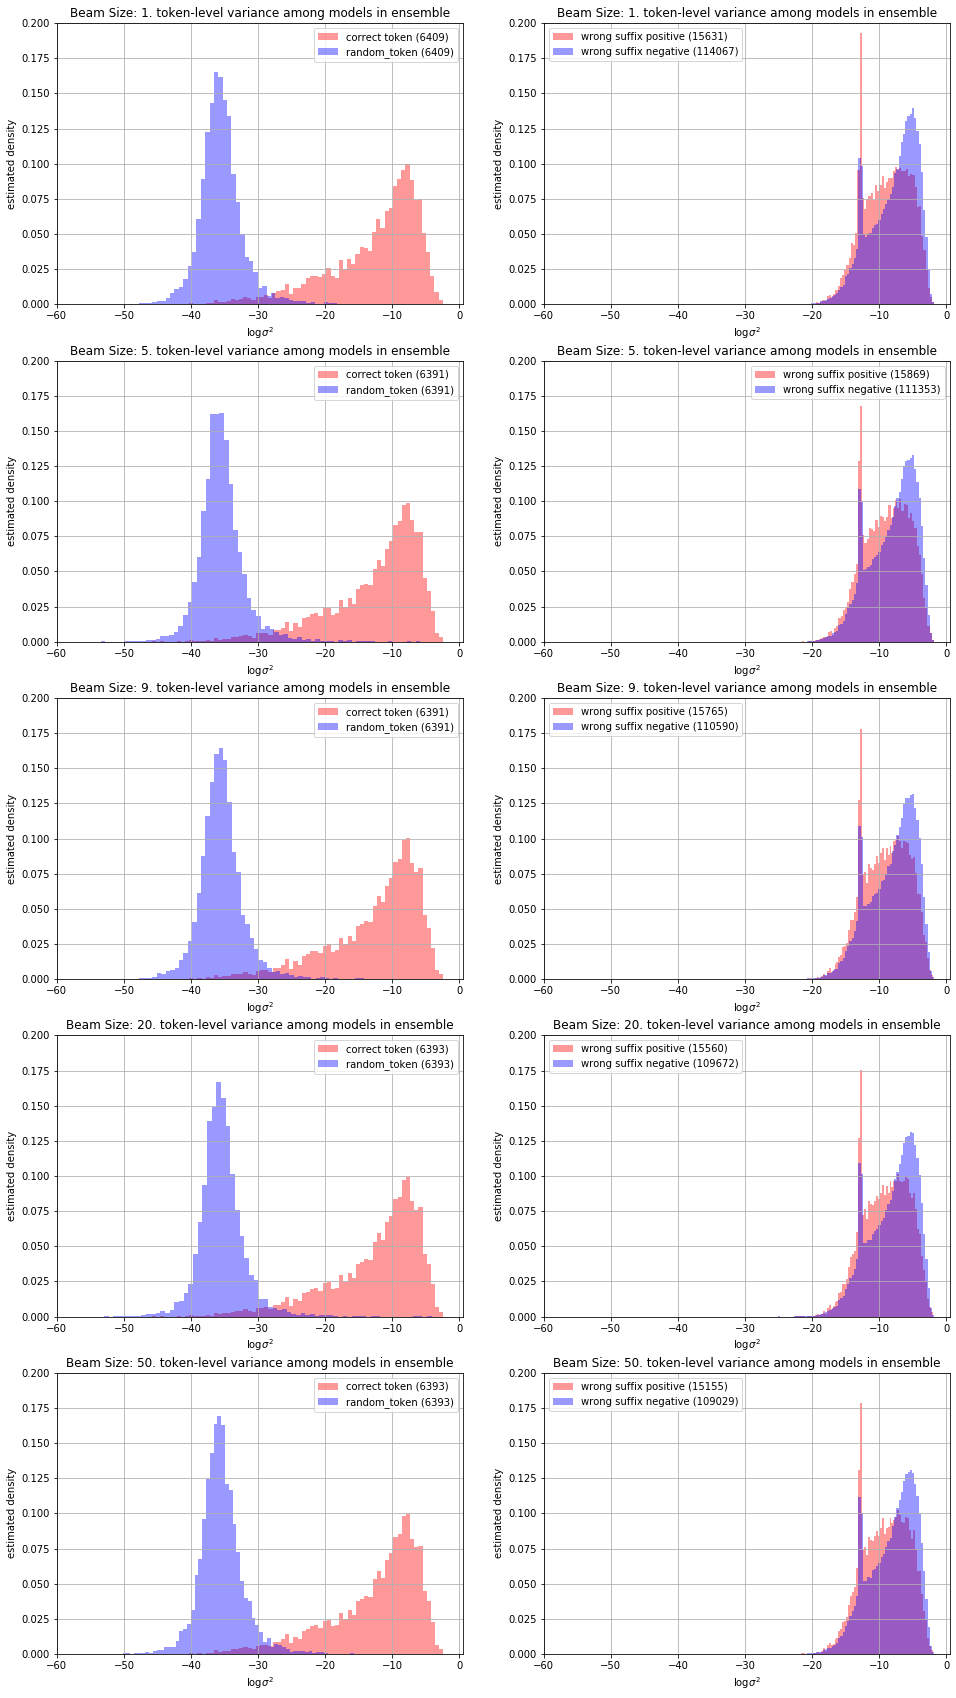

In [33]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models in ensemble'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT = 'inens_probs_var'
EOS_TOKEN = None
# EOS_TOKEN = None

plot_stats(
    beams,
    ('correct token', beam2stats_neg_true),
    ('random_token', beam2stats_random),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.log2
)

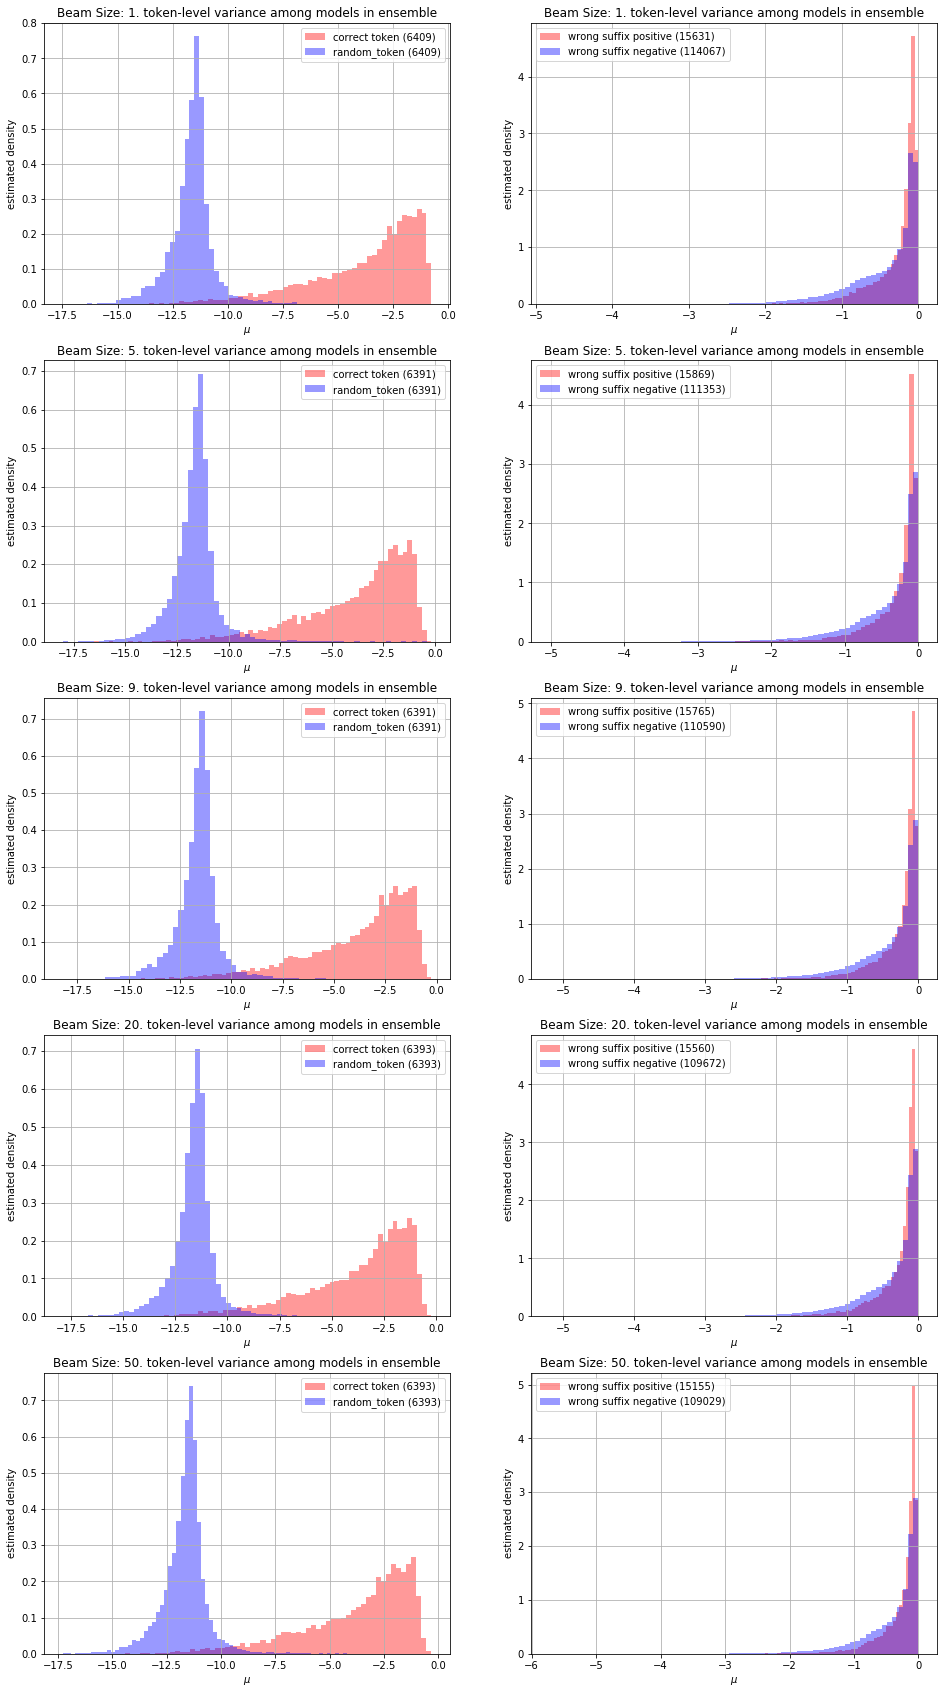

In [66]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None
XLIM = None
YLIM = None

TITLE = 'token-level variance among models in ensemble'
XLABEL = r'$\mu$'
YLABEL = 'estimated density'

STAT = 'inens_probs_mean'
EOS_TOKEN = None
# EOS_TOKEN = None

plot_stats(
    beams,
    ('correct token', beam2stats_neg_true),
    ('random_token', beam2stats_random),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN
)

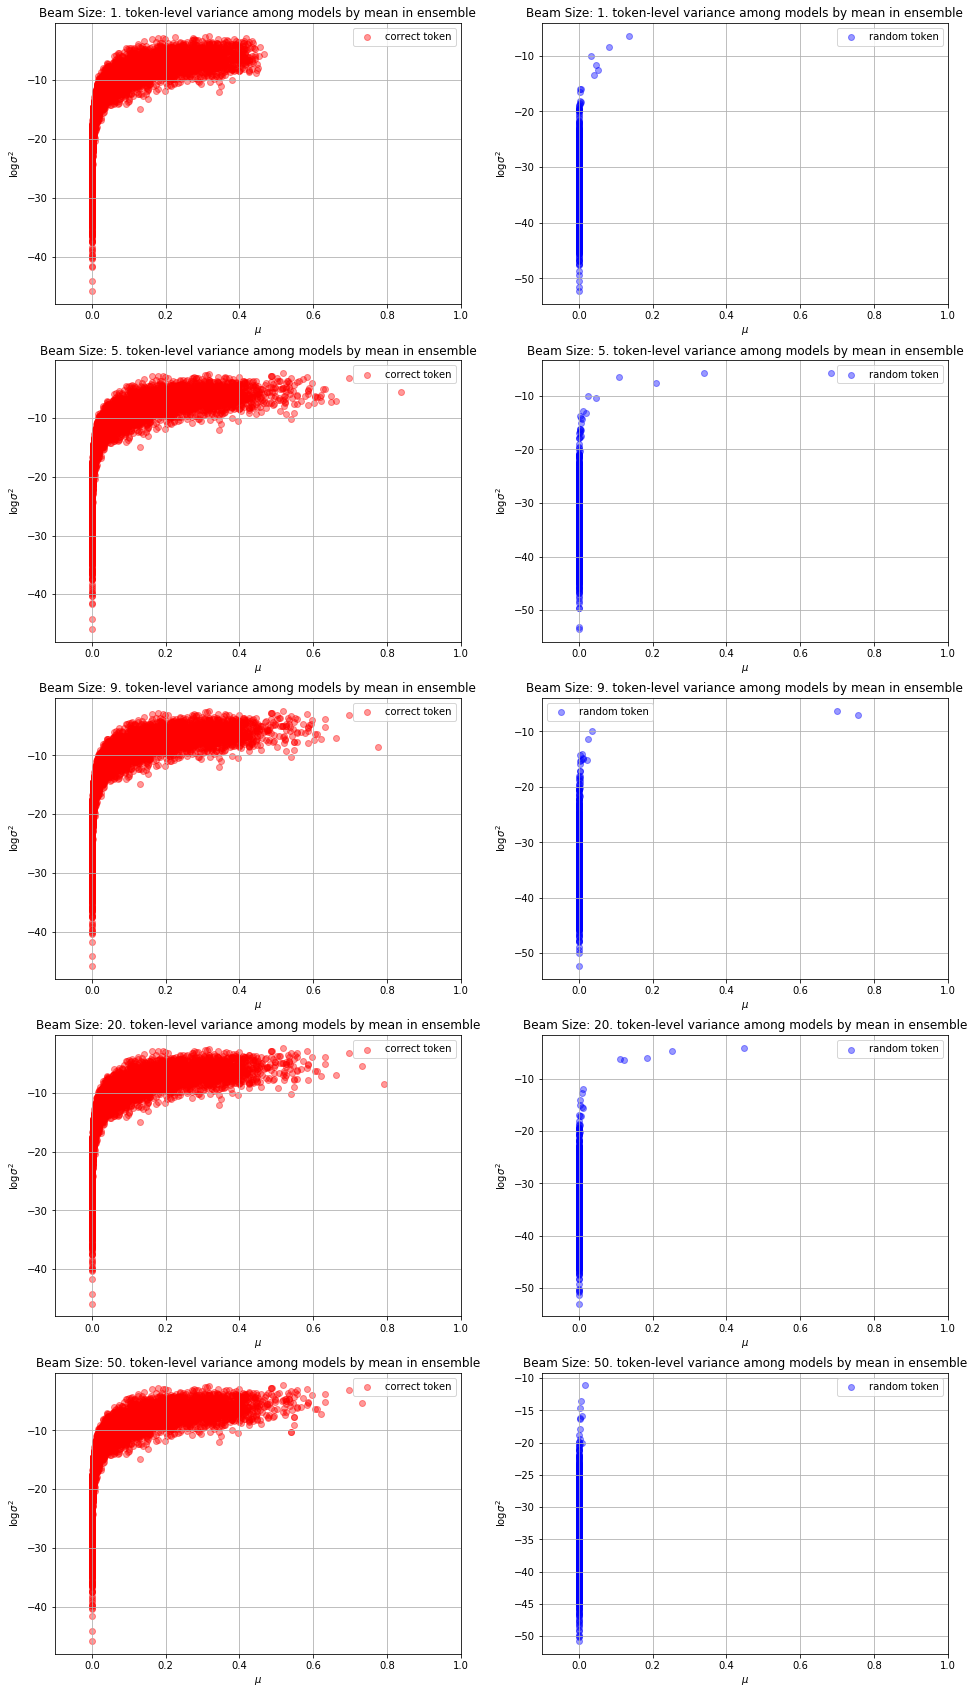

In [35]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None
XLIM = (-0.1, 1)

TITLE = 'token-level variance among models by mean in ensemble'
YLABEL = r'$\log \sigma^2$'
XLABEL = r'$\mu$'

STATX = 'inens_probs_mean'
STATY = 'inens_probs_var'
EOS_TOKEN = None

plot_stats_scatters(
    beams,
    ('correct token', beam2stats_neg_true),
    ('random token', beam2stats_random),
    STATX,
    STATY,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    map_func_x=np.exp,
    map_func_y=np.log2
)

#### Prob scaling experiment

In [63]:
def plot_stat(
    beams,
    stat_list_by_beam,
    name_list,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    map_func=lambda x: x
):
    density = stacked = normalized
        
    m = 3
    n = len(beams) // m + (1 if len(beams) % m != 0 else 0)
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, i + 1)
        for name, stat in zip(name_list, stat_list_by_beam[beam]):
            ax.hist(
                map_func(stat),
                density=density, stacked=stacked,
                alpha=.4,
                bins=70,
                label='{} ({})'.format(name, len(stat))
            )

        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

In [36]:
beam2stats_pos[1].keys()

dict_keys(['inens_probs_var', 'inens_probs_mean', 'softmax_probs_var_models', 'softmax_probs_entropy_models', 'softmax_probs_var_ens', 'softmax_probs_entropy_ens', 'prob', 'tokens'])

In [47]:
STAT = 'inens_probs_mean'
SCALER = 'inens_probs_var'
STATS_COLLECTIONS = [
    ('first error', beam2stats_neg),
    ('correct token', beam2stats_neg_true),
    ('random token', beam2stats_random),
]
STATS_NAMES, STATS_COLLECTIONS = zip(*STATS_COLLECTIONS)

transformer = lambda ens_logprobs, inens_var: np.exp(ens_logprobs - np.log(inens_var))

In [51]:
beam2stats_transformed = defaultdict(list)

for beam in beams:
    for stat_collection in STATS_COLLECTIONS:
        beam2stats_transformed[beam].append(
            transformer(stat_collection[beam][STAT], stat_collection[beam][SCALER])
        )

In [59]:
beam2stats_transformed[1]

[array([384.87087429,   4.99512112,   2.25883551, ...,  14.40859892,
          8.72225362,  14.40859892]),
 array([3.57006515e+01, 8.64568548e+00, 4.71928876e+00, ...,
        6.34312862e+04, 8.89508158e+00, 3.11737535e+01]),
 array([ 286945.20141418,   13726.29485013,  165273.45619696, ...,
         353430.70429312, 5114814.91350299, 2262044.93579984])]

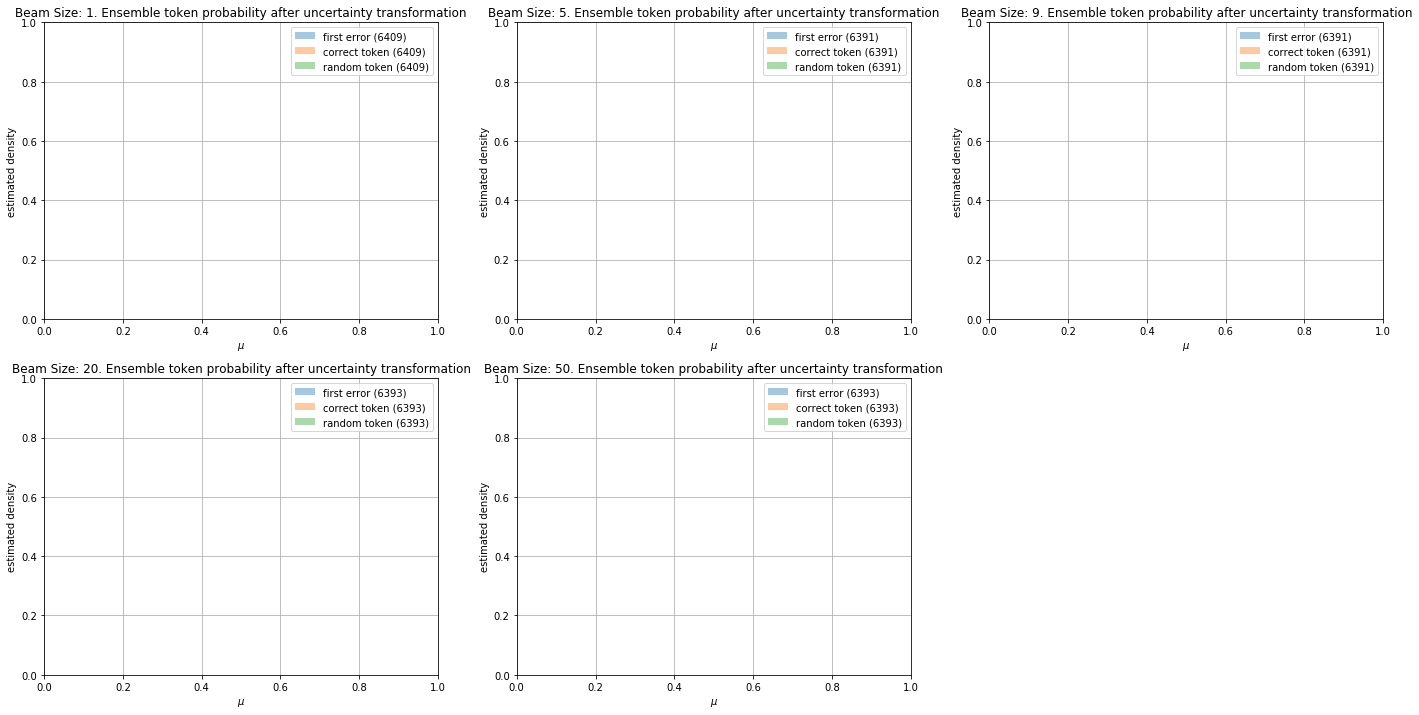

In [64]:
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble token probability after uncertainty transformation'
XLABEL = r'$\mu$'
YLABEL = 'estimated density'

plot_stat(
    beams,
    beam2stats_transformed,
    STATS_NAMES,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
)

##### Models' softmax variance

In [ ]:
beam2stats_pos[2].keys()

In [ ]:
YLIM = (0, 1.5)
XLIM = (-24, -12)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble softmax variance'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT_PATTERN = 'm{}_svar'

m = MODELS_NUM
n = len(beams)

plt.figure(figsize=(8 * m, 6 * n))
for i, beam in enumerate(sorted(beams)):
    for j in range(MODELS_NUM):
        ax = plt.subplot(n, m, i * m + j + 1)
        STAT = STAT_PATTERN.format(j)
        ax.hist(
            np.log2(np.array(beam2stats_pos[beam][STAT])),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='correct prefix ({})'.format(len(beam2stats_pos[beam][STAT]))
        )
        ax.hist(
            np.log2(np.array(beam2stats_neg[beam][STAT])),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='first error ({})'.format(len(beam2stats_neg[beam][STAT]))
        )    
        ax.hist(
            np.log2(np.array(beam2stats_wrong[beam][STAT])),
            density=density, stacked=stacked,
            color='black', alpha=.4,
            bins=70,
            label='wrong suffix ({})'.format(len(beam2stats_wrong[beam][STAT]))
        )
        ax.set_title('Beam Size: {}. {}'.format(beam, TITLE))
        ax.set_xlabel(XLABEL)
        ax.set_ylabel(YLABEL)
        if YLIM is not None:
            ax.set_ylim(YLIM)
        if XLIM is not None:
            ax.set_xlim(XLIM)
        ax.grid()
        ax.legend()

In [ ]:
YLIM = (0, 1)
XLIM = None

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble softmax entropy'
XLABEL = r'$\mathcal{H}(sofmax)$'
YLABEL = 'estimated density'

STAT_PATTERN = 'm{}_entropy'

m = MODELS_NUM
n = len(beams)

plt.figure(figsize=(8 * m, 6 * n))
for i, beam in enumerate(sorted(beams)):
    for j in range(MODELS_NUM):
        ax = plt.subplot(n, m, i * m + j + 1)
        STAT = STAT_PATTERN.format(j)
        ax.hist(
            np.array(beam2stats_pos[beam][STAT]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='correct prefix ({})'.format(len(beam2stats_pos[beam][STAT]))
        )
        ax.hist(
            np.array(beam2stats_neg[beam][STAT]),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='first error ({})'.format(len(beam2stats_neg[beam][STAT]))
        )    
        ax.hist(
            np.array(beam2stats_wrong[beam][STAT]),
            density=density, stacked=stacked,
            color='black', alpha=.4,
            bins=70,
            label='wrong suffix ({})'.format(len(beam2stats_wrong[beam][STAT]))
        )
        ax.set_title('Beam Size: {}. {}'.format(beam, TITLE))
        ax.set_xlabel(XLABEL)
        ax.set_ylabel(YLABEL)
        if YLIM is not None:
            ax.set_ylim(YLIM)
        if XLIM is not None:
            ax.set_xlim(XLIM)
        ax.grid()
        ax.legend()

---